# Classifier

## Import packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from time import time
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, mutual_info_classif, RFE, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB

import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pathlib import Path
import pickle

import datetime

## Import data

In [2]:
# read in normal dataset
df = pd.read_pickle("b5feat.pkl")
df.name = 'allfeatures_df'
df = df[df['trait', 'openness'].notna()]
df = df[df['trait', 'conscientiousness'].notna()]
df = df[df['trait', 'extraversion'].notna()]
df = df[df['trait', 'agreeableness'].notna()]
df = df[df['trait', 'neuroticism'].notna()]
df.name = 'allfeatures_df'
df.trait.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1568 entries, -Areopagan- to zyzee
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   agreeableness      1568 non-null   float32
 1   openness           1568 non-null   float32
 2   conscientiousness  1568 non-null   float32
 3   extraversion       1568 non-null   float32
 4   neuroticism        1568 non-null   float32
 5   big5_a             1568 non-null   int16  
 6   big5_o             1568 non-null   int16  
 7   big5_c             1568 non-null   int16  
 8   big5_e             1568 non-null   int16  
 9   big5_n             1568 non-null   int16  
 10  big5_a_multi       1568 non-null   int16  
 11  big5_o_multi       1568 non-null   int16  
 12  big5_c_multi       1568 non-null   int16  
 13  big5_e_multi       1568 non-null   int16  
 14  big5_n_multi       1568 non-null   int16  
dtypes: float32(5), int16(10)
memory usage: 73.5+ KB
<class 'pandas.cor

In [21]:
mbtidf = pd.read_pickle("b5mbtifeat.pkl")
mbtidf.name = 'b5mbtifeatures_df'
mbtidf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386 entries, -BlitzN9ne to zymmaster
Columns: 13000 entries, ('text', 'body') to ('lda', 'ldahundred')
dtypes: float64(5102), int64(7891), object(7)
memory usage: 38.3+ MB


In [3]:
# # show authors with missing data in the traits
# print("openness")
# for i in range(len(df['trait', 'openness'])):
#     if np.isnan(df.iloc[i]['trait', 'openness']):
#         print(df.iloc[i].name)
        
# print("\nconscientiousness")
# for i in range(len(df['trait', 'conscientiousness'])):
#     if np.isnan(df.iloc[i]['trait', 'conscientiousness']):
#         print(df.iloc[i].name)

# print("\nextraversion")
# for i in range(len(df['trait', 'extraversion'])):
#     if np.isnan(df.iloc[i]['trait', 'extraversion']):
#         print(df.iloc[i].name)

# print("\nagreeableness")
# for i in range(len(df['trait', 'agreeableness'])):
#     if np.isnan(df.iloc[i]['trait', 'agreeableness']):
#         print(df.iloc[i].name)

# print("\nneuroticism")
# for i in range(len(df['trait', 'neuroticism'])):
#     if np.isnan(df.iloc[i]['trait', 'neuroticism']):
#         print(df.iloc[i].name)

In [4]:
# # level 0 column names
# predictors = ori_augdf.columns
# featurelst = []
# for i in range(len(predictors)):
#     featurelst.append(predictors[i][0])
# featureset = set(featurelst)
# print(featureset)

In [5]:
# # create smaller dfs
# log_wordngrams_df = df[['trait', 'wordngram']]
# log_charngrams_df = df[['trait', 'charngram']]
# log_wordlists_df =  df[['trait', 'x_feat', 'lin_feat', 'psych', 'empath']]
# # log_posts_df = df[['trait', 'post', 'time', 'subreddit', 'lda']]
# # log_postswithoutsubreddits_df = df[['trait', 'post', 'time', 'lda']]
# log_posts_df = df[['trait', 'post', 'subtf', 'lda50', 'lda100']]
# log_postswithoutsubreddits_df = df[['trait', 'post', 'subtf', 'lda50', 'lda100']]


# log_wordngrams_df.name = 'wordngrams_df'
# log_charngrams_df.name = 'charngrams_df'
# log_wordlists_df.name = 'wordlists_df'
# log_posts_df.name = 'posts_df'
# log_postswithoutsubreddits_df.name = 'posts_nosubreddits_df'

## Define input and labels

In [24]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, classes, trait_name):
    featuredf = df.drop(['trait'], axis=1, level=0)
    try:
        featuredf.drop(['text'], axis=1, level=0, inplace=True)
    except KeyError:
        pass
    try:
        featuredf.drop(['data'], axis=1, level=0, inplace=True)
    except KeyError:
        pass
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols] 
    
    if classes=='binary':
        if trait_name == 'agreeableness':
            y = df['trait', 'big5_a']
        elif trait_name == 'openness':
            y = df['trait', 'big5_o']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'big5_c']
        elif trait_name == 'extraversion':
            y = df['trait', 'big5_e']
        elif trait_name == 'neuroticism':
            y = df['trait', 'big5_n']   
    elif classes=='multi':
        if trait_name == 'agreeableness':
            y = df['trait', 'big5_a_multi']
        elif trait_name == 'openness':
            y = df['trait', 'big5_o_multi']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'big5_c_multi']
        elif trait_name == 'extraversion':
            y = df['trait', 'big5_e_multi']
        elif trait_name == 'neuroticism':
            y = df['trait', 'big5_n_multi'] 
    elif classes=='linear':
        if trait_name == 'agreeableness':
            y = df['trait', 'agreeableness']
        elif trait_name == 'openness':
            y = df['trait', 'openness']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'conscientiousness']
        elif trait_name == 'extraversion':
            y = df['trait', 'extraversion']
        elif trait_name == 'neuroticism':
            y = df['trait', 'neuroticism']  
    elif classes=='mbti':
        if trait_name == 'mbti_ei':
            y = df['trait', 'mbti_ei']
        elif trait_name == 'mbti_ns':
            y = df['trait', 'mbti_ns']
        elif trait_name == 'mbti_tf':
            y = df['trait', 'mbti_tf']
        elif trait_name == 'mbti_jp':
            y = df['trait', 'mbti_jp'] 
    return x,y 

### Functions for nested stratified cross validation

In [19]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores


def get_classifier(classifier):
    if classifier == 'log':
        return LogisticRegression(class_weight='balanced', n_jobs=-1, max_iter=1000)
    elif classifier == 'mcc':
        return DummyClassifier(strategy="most_frequent")
    elif classifier == 'mlp':
        return MLPClassifier()
    elif classifier == 'svm':
        return svm.SVC(class_weight='balanced', probability=True, max_iter=1000)
    elif classifier == 'multilog':
        return LogisticRegression(multi_class='multinomial', n_jobs=-1, max_iter=1000)
    elif classifier == 'knn':
        return KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    elif classifier == 'tree':
        return DecisionTreeClassifier(class_weight='balanced', random_state=0)
    elif classifier == 'rfc':
        return RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
    elif classifier == 'nb':
        return GaussianNB()
    elif classifier == 'boost':
        return GradientBoostingClassifier(random_state=0)

    
def get_featureselection(fs, classifier, n_feat):
    if fs == 'anova':
        return SelectKBest(f_classif, k=n_feat)
    if fs == 'mutual':
        return SelectKBest(mutual_info_classif, k=n_feat)
    if fs == 'sequential_forward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='forward', n_jobs=-1)
    if fs == 'sequential_backward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='backward', n_jobs=-1)


    
def create_pipeline_cv(classifier, fs, dim, n_feat, doublefs):
    if dim:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('pca', PCA(n_components=100)),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    elif doublefs:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('firstfs', SelectKBest(f_classif, k=100)),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    else:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    return pipeline

def get_params(classifier):
    if classifier == 'log':
        params = {'classification__solver': ['lbfgs', 'liblinear', 'saga'], 
                  'classification__C': [10**x for x in range(-3,5)]}
    if classifier == 'multilog':
        params = {'classification__class_weight': [None, 'balanced'], 
                  'classification__solver': ['lbfgs', 'saga']}
    elif classifier == 'mlp':
        params = {'classification__hidden_layer_sizes': [(50,), (100,), (200,), (500,)]}
    elif classifier == 'svm':
        params = {'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'classification__gamma': ['scale', 'auto'], 
                  'classification__C': [10**x for x in range(-3,5)]}
    elif classifier == 'mcc' or classifier == 'nb':
        params = {}
    elif classifier == 'rfc':
        params = {'classification__criterion': ['gini', 'entropy'],
                 'classification__max_depth': [2, 5, 10]}
    elif classifier == 'tree':
        params = {'classification__criterion': ['gini', 'entropy'],
                 'classification__max_depth': [2, 5, 10]}
    elif classifier == 'boost':
        params = {'classification__learning_rate': [10**x for x in range(-3,3)],
                'classification__max_depth': [2, 5, 10]}
    return params


def define_outputname(traits, df, option, classes, fs, dim, n_feat, train=False):
    if train:
        if len(traits) ==1:
            outputname = "b5_" + "train_" +df.name +"_" +str(option) +"_" +str(classes) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        elif traits[0] == 'openness':
            outputname = "b5_" + "train_" +df.name +"_" +str(option) +"_" +str(classes) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        else:
            outputname = "mbti_" + "train_" +df.name +"_" +str(option) +"_" +str(classes) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
    else:
        if len(traits) ==1:
            outputname = "b5_" +df.name +"_" +str(option) +"_" +str(classes) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        elif traits[0] == 'openness':
            outputname = "b5_" +df.name +"_" +str(option) +"_" +str(classes) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        else:
            outputname = "mbti_" +df.name +"_" +str(option) +"_" +str(classes) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
    return outputname


def create_inner(option, replication):
    if replication and option == 'log':
        cv_inner = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    else:
        cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    return cv_inner

def linear_plot(val_target, y_pred, outputname, trait_name):
    linear_plot = sns.regplot(x=val_target, y=y_pred, ci=None, color="b")
    plt.savefig(Path(p, outputname + "_" + trait_name + '_ytruepred_plot.png'))
    return linear_plot

def save_predictors(names, predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5, j):
    if j==1:
        predictors_fold1.append(list(names))
    elif j==2:
        predictors_fold2.append(list(names))
    elif j==3:
        predictors_fold3.append(list(names))
    elif j==4:
        predictors_fold4.append(list(names))
    elif j==5:
        predictors_fold5.append(list(names))
    return predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5

def save_acc_folds(acc, acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5, j):
    if j==1:
        acc_fold1.append(acc)
    elif j==2:
        acc_fold2.append(acc)
    elif j==3:
        acc_fold3.append(acc)
    elif j==4:
        acc_fold4.append(acc)
    elif j==5:
        acc_fold5.append(acc)
    return acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5

def save_f1score_folds(f1_macro, f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5, j):
    if j==1:
        f1score_fold1.append(f1_macro)
    elif j==2:
        f1score_fold2.append(f1_macro)
    elif j==3:
        f1score_fold3.append(f1_macro)
    elif j==4:
        f1score_fold4.append(f1_macro)
    elif j==5:
        f1score_fold5.append(f1_macro)
    return f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5


def save_params_folds(foldparams, params_fold1, params_fold2, params_fold3, params_fold4, params_fold5, j):
    if j==1:
        params_fold1.append(foldparams)
    elif j==2:
        params_fold2.append(foldparams)
    elif j==3:
        params_fold3.append(foldparams)
    elif j==4:
        params_fold4.append(foldparams)
    elif j==5:
        params_fold5.append(foldparams)
    return params_fold1, params_fold2, params_fold3, params_fold4, params_fold5


## Classifier

In [27]:
def classify_cv(df, traits, classes, clf_lst, fs, dim, n_feat, replication=False, train=False, doublefs=False):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        tstart = time()
        print("Current time: ", str(datetime.datetime.now()))
        # iterate through list of classifiers
        for option in clf_lst:
            print("Classifier: ", option, "\n")
            
            # initiate saving to files
            outputname = define_outputname(traits, df, option, classes, fs, dim, n_feat)
            output = {'Traits': traits}
            
            # empty lists to save data
            acc_traits, f1_traits  = [], []
            acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5 = [],[],[],[],[]
            f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5 = [],[],[],[],[]
            params_fold1, params_fold2, params_fold3, params_fold4, params_fold5 = [],[],[],[],[]
            predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = [],[],[],[],[]
    
            # iterate through traits or types
            for trait_name in traits:
                print("\nTrait to predict: ", trait_name, "(", option, ")\n")
                # define input and label columns
                x,y = trait(df, classes, trait_name)
                
                # outer loop
                cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
                cv_outer_lst = cv_outer.split(x, y)
                
                # empty lists for saving
                f1macro_lst, accuracy_lst, tpr_lst, ytrue_lst, ypred_lst, cm_traits = [],[],[],[],[],[]
                
                # initiate plotting
                mean_fpr = np.linspace(0, 1, 101)
                plt.figure(figsize=(5, 5))
                p = Path('/home/sophia/ma_py/Big5-NLP/results/')
                
                # count folds
                j=1
                
                # initiate nesting
                for train_idx, val_idx in cv_outer_lst:
                    train_data, val_data = x.iloc[train_idx], x.iloc[val_idx]
                    train_target, val_target = y.iloc[train_idx], y.iloc[val_idx]
                    
#                     print("Fold No. ", j)
#                     print("Length of train and test: ", len(train_data), len(val_data))
#                     print("Total users in this fold: ", (len(train_data) + len(val_data)))
            
                    clf = create_pipeline_cv(option, fs, dim, n_feat, doublefs)

                    # grid search
                    cv_inner = create_inner(option, replication)
                    params = get_params(option)
                    gd_search = GridSearchCV(clf, params, scoring = 'f1_macro', n_jobs=-1, cv=cv_inner).fit(train_data, train_target)
                    best_model = gd_search.best_estimator_
                    if dim == False:
                        # save names of predictors
                        names = get_names(train_data, best_model)
                        predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = save_predictors(names, predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5, j)

                    # train with best model from grid search
                    clfnew = best_model.fit(train_data, train_target)
                    if train: 
                        y_pred = clfnew.predict(train_data)
                        y_score = clfnew.predict(train_data)
                        fpr, tpr, _ = roc_curve(train_target, y_score[:, 1])
                        cm = confusion_matrix(train_target, y_pred)
                        f1_macro = f1_score(train_target, y_pred, average='macro')
                        acc = accuracy_score(train_target, y_pred)
                        
                    else:
                        y_pred = clfnew.predict(val_data)
                        y_score = clfnew.predict_proba(val_data)
                        fpr, tpr, _ = roc_curve(val_target, y_score[:, 1])
                        cm = confusion_matrix(val_target, y_pred)
                        f1_macro = f1_score(val_target, y_pred, average='macro')
                        acc = accuracy_score(val_target, y_pred)

                    # prepare plots
                    plt.plot(fpr, tpr, 'b', alpha=0.15)
                    tpr = np.interp(mean_fpr, fpr, tpr)
                    tpr[0] = 0.0
                    tpr_lst.append(tpr)

                    # save scores in lists
                    cm_traits.append(cm)
                    
                    f1macro_lst.append(f1_macro)
                    f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5 = save_f1score_folds(f1_macro, f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5, j)
                    
                    accuracy_lst.append(acc)
                    acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5 = save_acc_folds(acc, acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5, j)
                    foldparams = gd_search.best_params_
                    params_fold1, params_fold2, params_fold3, params_fold4, params_fold5 = save_params_folds(foldparams, params_fold1, params_fold2, params_fold3, params_fold4, params_fold5, j)
#                         print("\tVal Accuracy: ", acc, "Val F1-score:", f1_macro , 
#                               "Best GS F1-score:",gd_search.best_score_, "\nBest Params:",foldparams)

                    j+=1
                    
                    
                  # Training final model

                # average results from the outer loop
                acc_avg = np.mean(accuracy_lst)
                acc_traits.append(round(acc_avg, 4))
                print("Average accuracy: ", acc_avg)
                f1macro_avg = np.mean(f1macro_lst)
                f1_traits.append(round(f1macro_avg, 4))
                print("\n\nAverage f1 macro score: ", f1macro_avg)

                # plots
                tprs = np.array(tpr_lst)
                mean_tprs = tprs.mean(axis=0)
                std = tprs.std(axis=0)
                tprs_upper = np.minimum(mean_tprs + std, 1)
                tprs_lower = mean_tprs - std

                plt.plot(mean_fpr, mean_tprs, 'b')
                plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
                np.save(Path(p, outputname + "_" + trait_name + '_meantprs.npy'), mean_tprs)

                title1 = "ROC plot for trait " + trait_name
                plt.plot([0, 1], [0, 1],'r--')
                plt.xlim([-0.01, 1.01])
                plt.ylim([-0.01, 1.01])
                plt.ylabel('True Positive Rate')
                plt.xlabel('False Positive Rate')
                plt.axes().set_aspect('equal', 'datalim')
                plt.title(title1)
                plt.savefig(Path(p, outputname + "_" + trait_name + '_roc_plot.png'))
                plt.show()

                print("Total number of users in confusion matrix: ", np.sum(cm_traits))
                title2 = "Confusion matrix for trait " + trait_name
                plt.figure(figsize=(5, 5))
                mean_cm = np.sum(cm_traits, axis=0)
                disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm).plot(cmap=plt.cm.Blues, values_format = '.4f')
                disp.ax_.set_title(title2)
                plt.savefig(Path(p, outputname + "_" + trait_name + '_cm.png'))
                plt.show()

            # average all traits
            print("Total accuracy: ", np.mean(acc_traits), "Total F1 macro: ", np.mean(f1_traits))
            
            # save results to csv
            output.update({'acc': acc_traits, 'f1_macro': f1_traits})
            output.update({'acc_fold1': acc_fold1, 'acc_fold2': acc_fold2, 'acc_fold3': acc_fold3, 'acc_fold4': acc_fold4, 'acc_fold5': acc_fold5})
            output.update({'f1score_fold1': f1score_fold1, 'f1score_fold2': f1score_fold2, 'f1score_fold3': f1score_fold3, 'f1score_fold4': f1score_fold4, 'f1score_fold5': f1score_fold5})
            output.update({'params_fold1': params_fold1, 'params_fold2': params_fold2, 'params_fold3': params_fold3, 'params_fold4': params_fold4, 'params_fold5': params_fold5})
            if dim==False:
                output.update({'predictors_fold1': predictors_fold1, 'predictors_fold2': predictors_fold2, 'predictors_fold3': predictors_fold3, 'predictors_fold4': predictors_fold4, 'predictors_fold5': predictors_fold5})
            outputdf = pd.DataFrame(output)
            outputdf.to_csv(Path(p, outputname + '.csv'), index=False)
            print("Time for entire process: %0.2fs" % (time() - tstart))
            

big5_traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
mbti_traits =['mbti_ei', 'mbti_ns', 'mbti_tf', 'mbti_jp']

all_clf = ['mcc', 'log', 'mlp', 'svm']
new_clf = ['log', 'mlp', 'svm', 'nb', 'tree', 'rfc', 'boost']
onlynew_clf = ['nb', 'tree', 'rfc', 'boost']
exp_clf = ['log', 'mlp', 'rfc', 'boost']
regres = ['linear', 'rfc_reg']

## Methodological replication

Current time:  2021-05-15 17:25:12.799278
Classifier:  mcc 


Trait to predict:  openness ( mcc )

Average accuracy:  0.7098207199690686


Average f1 macro score:  0.4151433195843993


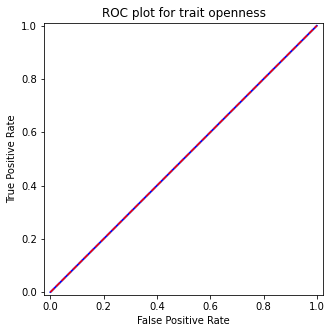

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

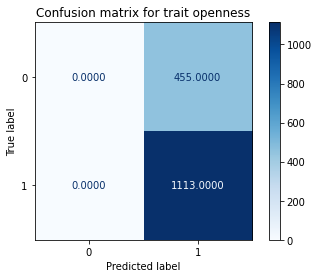


Trait to predict:  conscientiousness ( mcc )

Average accuracy:  0.6218127429234244


Average f1 macro score:  0.38340578252865737


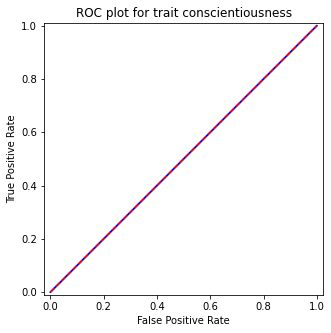

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

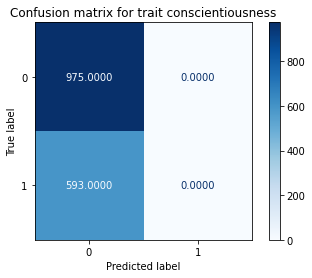


Trait to predict:  extraversion ( mcc )

Average accuracy:  0.6498728149610306


Average f1 macro score:  0.39389243468907004


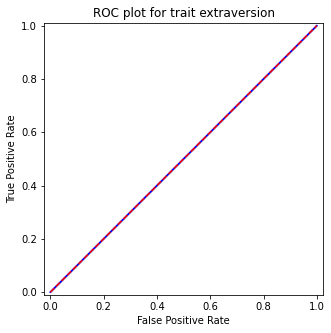

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

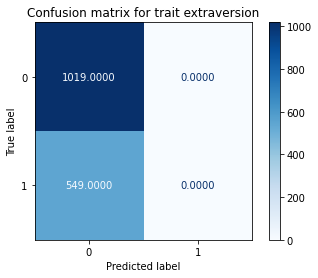


Trait to predict:  agreeableness ( mcc )

Average accuracy:  0.5650515862518061


Average f1 macro score:  0.36104303884387196


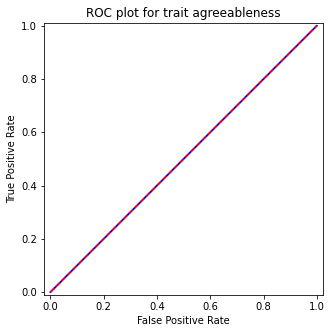

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

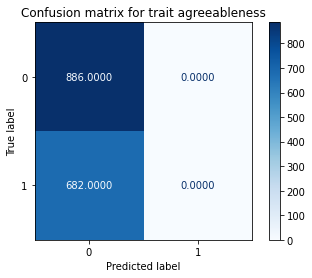


Trait to predict:  neuroticism ( mcc )

Average accuracy:  0.5044647036079852


Average f1 macro score:  0.3353113392929214


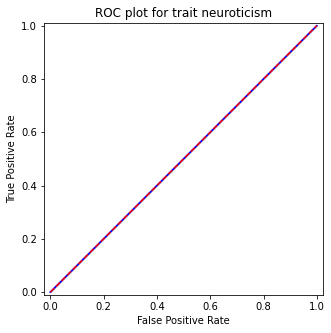

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

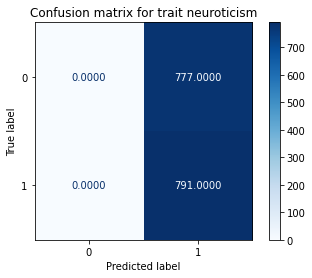

Total accuracy:  0.61022 Total F1 macro:  0.37773999999999996
Time for entire process: 118.34s
Classifier:  log 


Trait to predict:  openness ( log )

Average accuracy:  0.542111475142956


Average f1 macro score:  0.5156144225976176


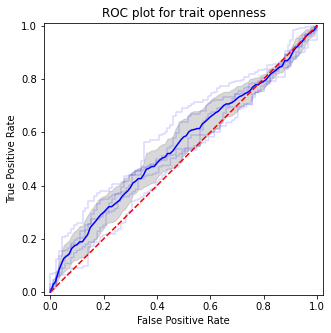

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

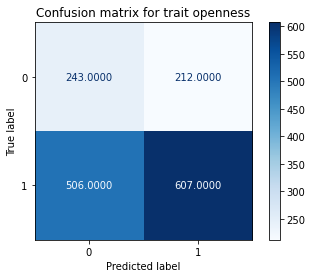


Trait to predict:  conscientiousness ( log )

Average accuracy:  0.5344885126472803


Average f1 macro score:  0.5185556060381113


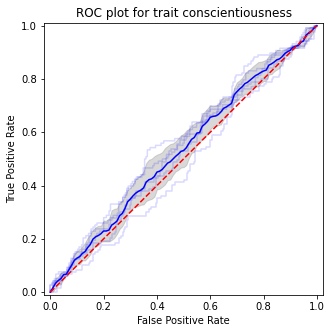

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

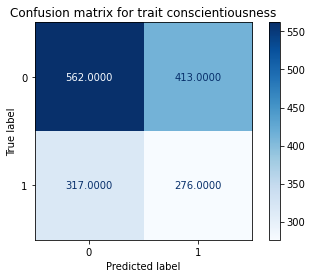


Trait to predict:  extraversion ( log )

Average accuracy:  0.5867585112228078


Average f1 macro score:  0.5656135600933229


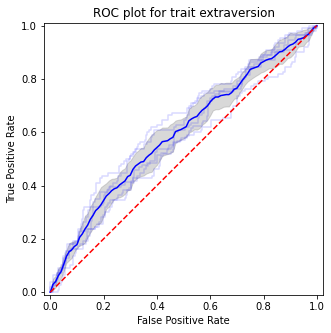

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

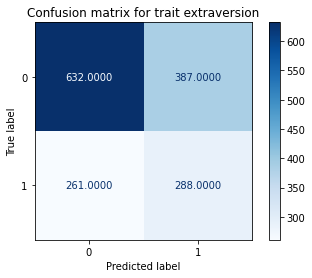


Trait to predict:  agreeableness ( log )

Average accuracy:  0.560623511935044


Average f1 macro score:  0.5559501327575651


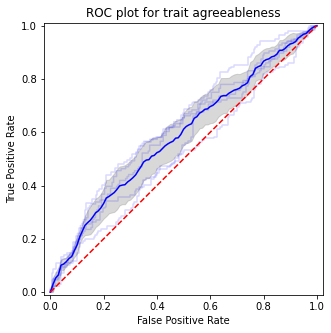

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

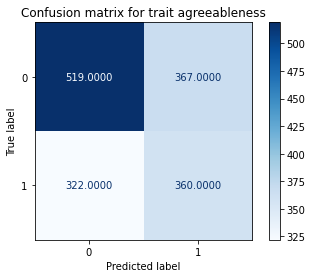


Trait to predict:  neuroticism ( log )

Average accuracy:  0.5606133371319265


Average f1 macro score:  0.5604622374172157


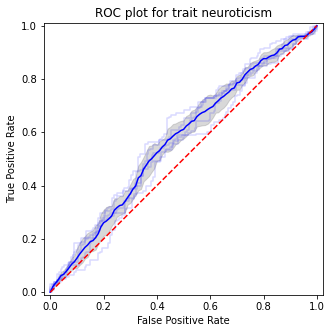

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

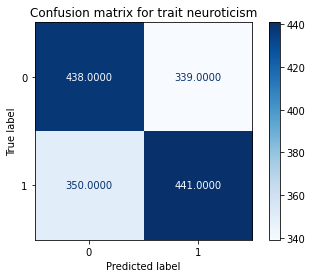

Total accuracy:  0.5569200000000001 Total F1 macro:  0.5432599999999999
Time for entire process: 1806.05s
Classifier:  mlp 


Trait to predict:  openness ( mlp )

Average accuracy:  0.6339370383183086


Average f1 macro score:  0.49895587977621814


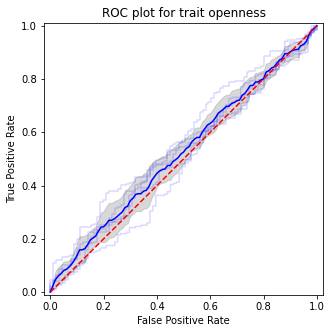

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

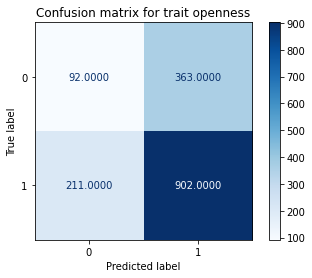


Trait to predict:  conscientiousness ( mlp )

Average accuracy:  0.5369915142141999


Average f1 macro score:  0.49536454125261187


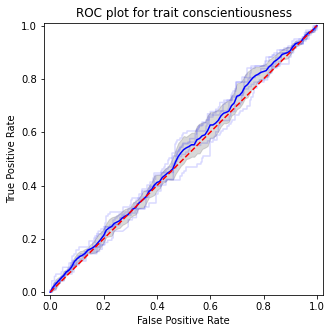

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

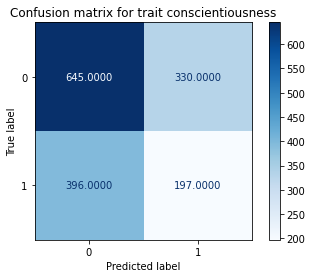


Trait to predict:  extraversion ( mlp )

Average accuracy:  0.6377790439754991


Average f1 macro score:  0.5733373523882068


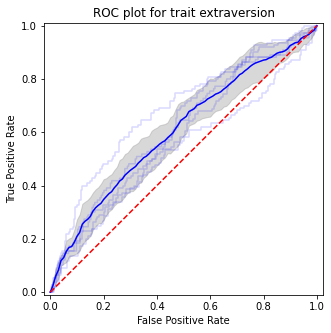

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

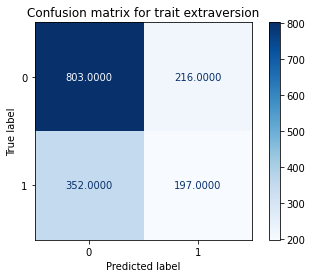


Trait to predict:  agreeableness ( mlp )

Average accuracy:  0.5574306587167538


Average f1 macro score:  0.5423683352864167


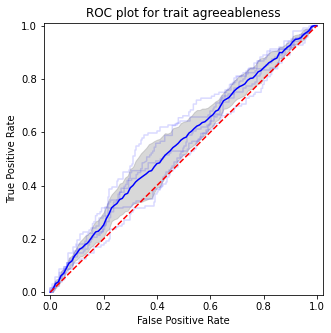

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

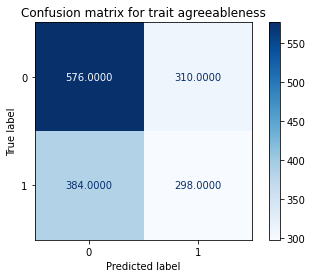


Trait to predict:  neuroticism ( mlp )

Average accuracy:  0.5338047658777803


Average f1 macro score:  0.532899413849518


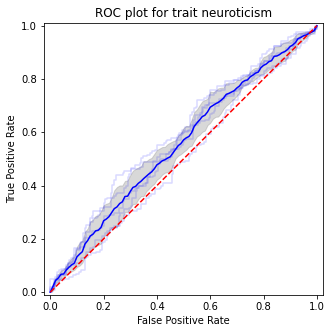

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

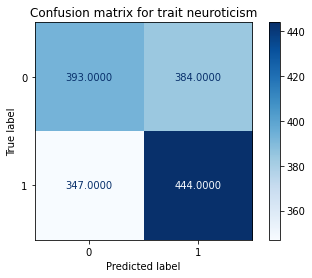

Total accuracy:  0.5799799999999999 Total F1 macro:  0.5286000000000001
Time for entire process: 2307.83s
Classifier:  svm 


Trait to predict:  openness ( svm )

Average accuracy:  0.5726826885899758


Average f1 macro score:  0.5083140676391714


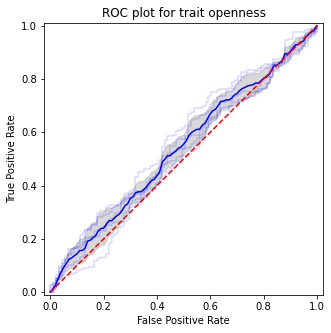

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

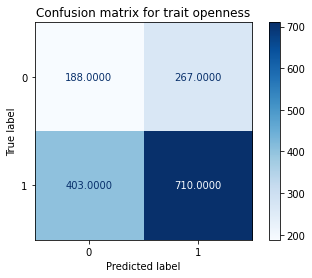


Trait to predict:  conscientiousness ( svm )

Average accuracy:  0.5134470198001668


Average f1 macro score:  0.500244948048435


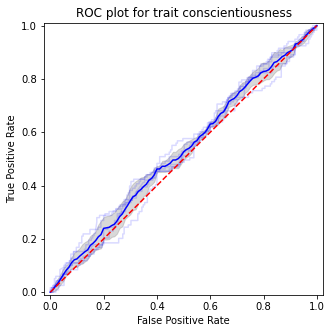

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

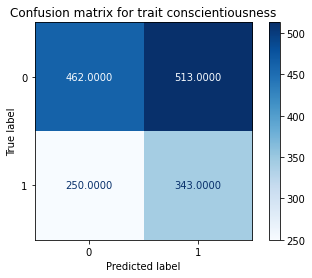


Trait to predict:  extraversion ( svm )

Average accuracy:  0.58226328320547


Average f1 macro score:  0.5580857480142556


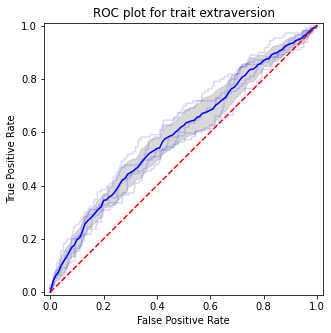

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

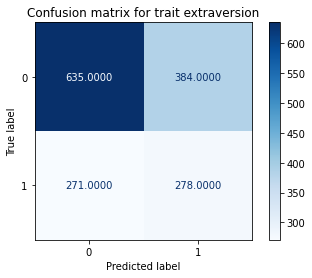


Trait to predict:  agreeableness ( svm )

Average accuracy:  0.527976638652042


Average f1 macro score:  0.48659596036997954


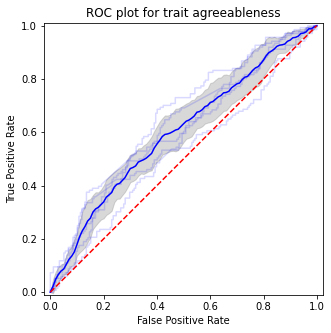

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

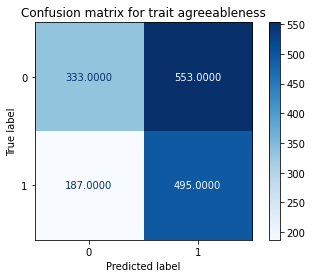


Trait to predict:  neuroticism ( svm )

Average accuracy:  0.5491219144909547


Average f1 macro score:  0.5458948991383072


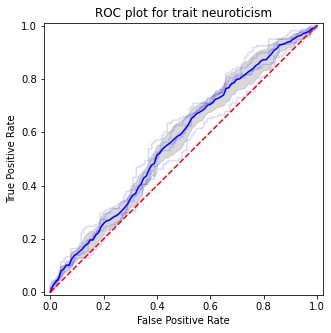

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

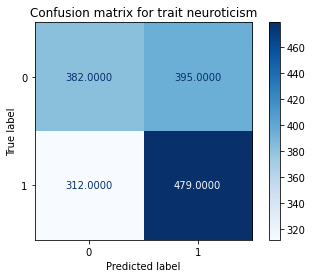

Total accuracy:  0.5491 Total F1 macro:  0.51982
Time for entire process: 4739.48s


In [25]:
classify_cv(df, big5_traits, 'binary', all_clf, 'anova', dim=False, n_feat=30, replication=True)

In [ ]:
classify_cv(df, big5_traits, 'binary', all_clf, 'anova', dim=False, n_feat=30, train=True, replication=True)

Current time:  2021-05-15 19:46:10.892329
Classifier:  log 


Trait to predict:  openness ( log )

Average accuracy:  0.5650963553855233


Average f1 macro score:  0.5341865361832546


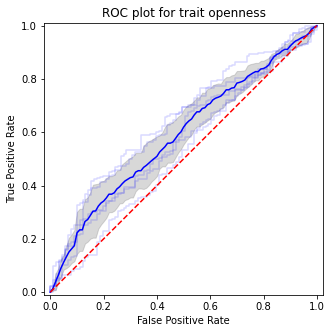

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

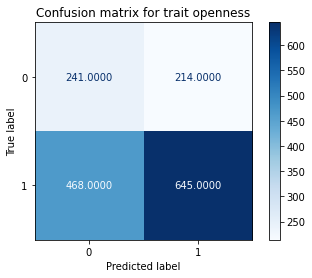


Trait to predict:  conscientiousness ( log )

Average accuracy:  0.5268024663722757


Average f1 macro score:  0.5172286255165488


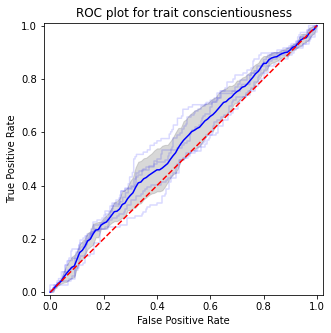

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

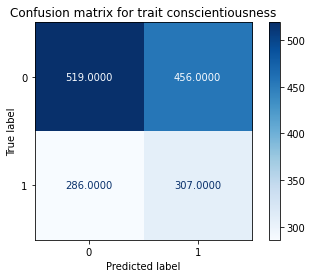


Trait to predict:  extraversion ( log )

Average accuracy:  0.5796890580167273


Average f1 macro score:  0.5643817715649193


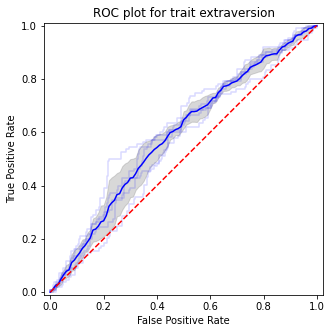

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

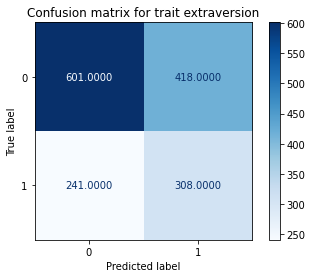


Trait to predict:  agreeableness ( log )

Average accuracy:  0.5427565576606093


Average f1 macro score:  0.5405010530186409


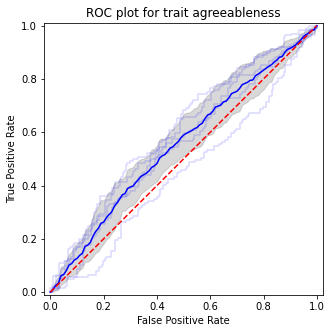

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

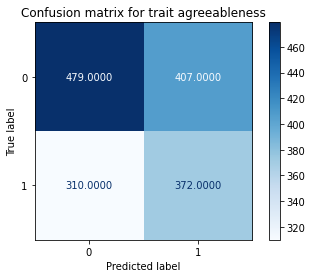


Trait to predict:  neuroticism ( log )

Average accuracy:  0.5350705113856046


Average f1 macro score:  0.533949680055918


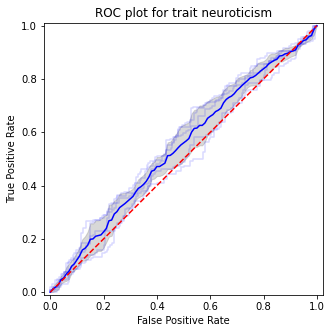

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

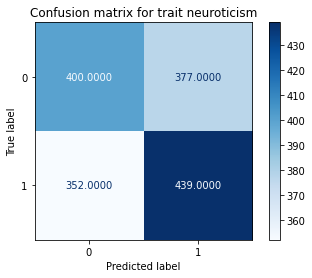

Total accuracy:  0.5499 Total F1 macro:  0.53804
Time for entire process: 3970.61s


In [29]:
classify_cv(df, big5_traits, 'binary', ['log'], 'anova', n_feat=30, dim=True, replication=True)

In [ ]:
print("Logistic regression with subsets of the features")
print("LR with word ngrams")
classify_cv(log_wordngrams_df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=30)

In [ ]:
print("LR with char ngrams")
classify_cv(log_charngrams_df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=30)

In [ ]:
print("LR with wordlists")
classify_cv(log_wordlists_df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=30)

In [ ]:
print("LR with posts features")
classify_cv(log_posts_df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=30)

## Experiments

### N features

Current time:  2021-05-16 17:15:22.012550
Classifier:  log 


Trait to predict:  openness ( log )

Average accuracy:  0.5401843674324902


Average f1 macro score:  0.5082502437210609


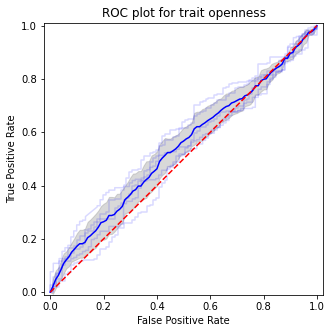

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

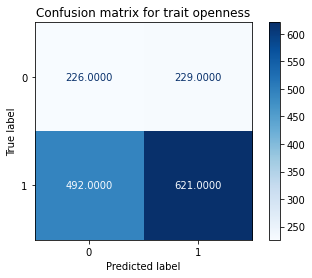


Trait to predict:  conscientiousness ( log )

Average accuracy:  0.5491381941759428


Average f1 macro score:  0.5315034921614874


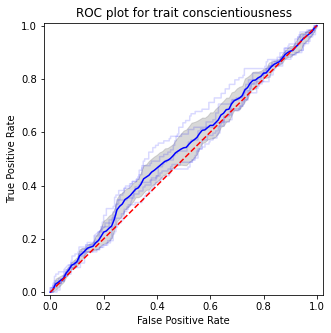

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

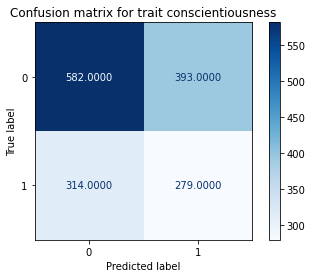


Trait to predict:  extraversion ( log )

Average accuracy:  0.5695590240328849


Average f1 macro score:  0.5452411673663903


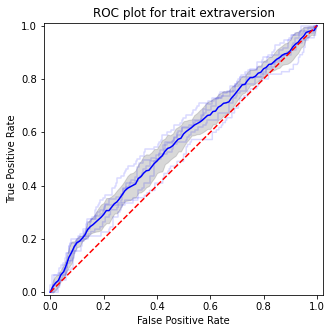

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

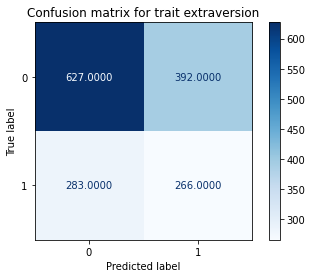


Trait to predict:  agreeableness ( log )

Average accuracy:  0.5676298813617957


Average f1 macro score:  0.5610207784023783


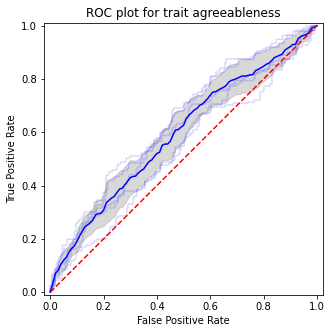

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

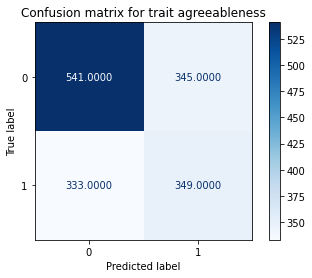


Trait to predict:  neuroticism ( log )

Average accuracy:  0.5408253800288965


Average f1 macro score:  0.5404946947125573


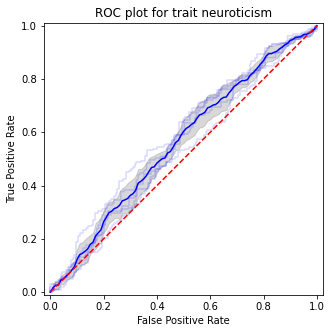

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

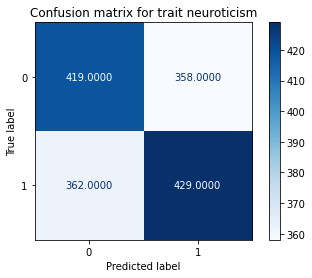

Total accuracy:  0.5534600000000001 Total F1 macro:  0.5372999999999999
Time for entire process: 809.88s


In [29]:
classify_cv(df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=20)

Current time:  2021-05-15 20:52:21.509061
Classifier:  log 


Trait to predict:  openness ( log )

Average accuracy:  0.5370037239779409


Average f1 macro score:  0.5098510439118018


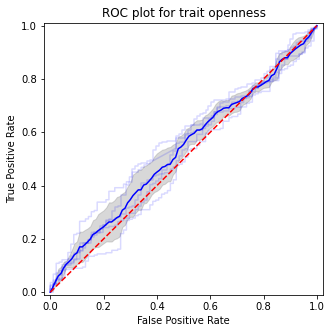

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

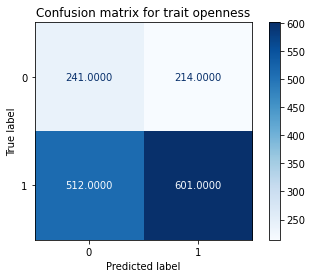


Trait to predict:  conscientiousness ( log )

Average accuracy:  0.5197920270242771


Average f1 macro score:  0.5036254660178948


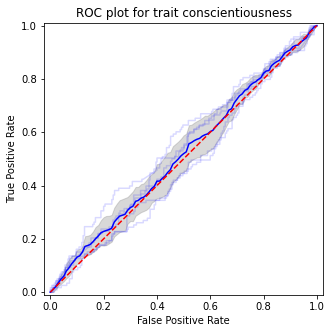

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

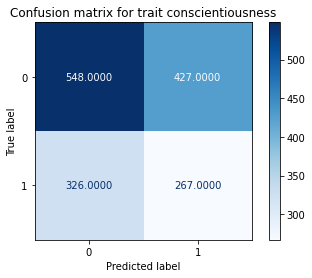


Trait to predict:  extraversion ( log )

Average accuracy:  0.5637878757046051


Average f1 macro score:  0.533149447964412


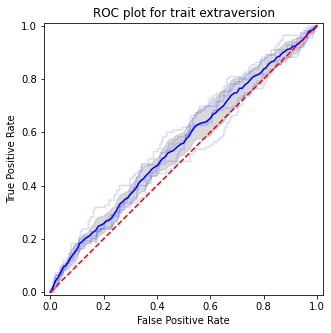

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

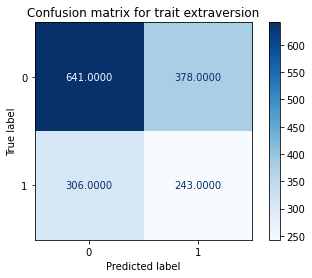


Trait to predict:  agreeableness ( log )

Average accuracy:  0.5765552186565189


Average f1 macro score:  0.5708157644998422


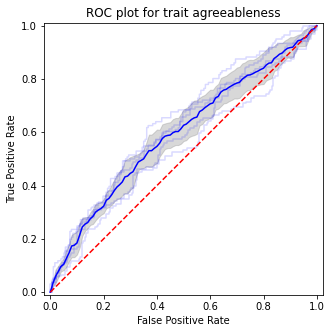

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

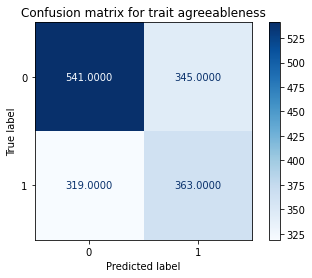


Trait to predict:  neuroticism ( log )

Average accuracy:  0.5420728108911093


Average f1 macro score:  0.5418372955445964


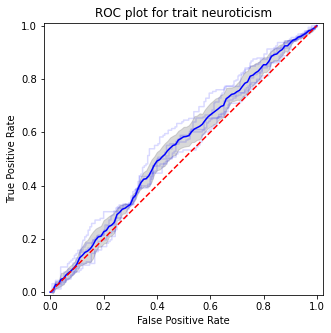

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

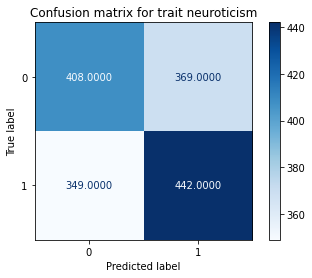

Total accuracy:  0.54786 Total F1 macro:  0.53184
Time for entire process: 803.93s


In [30]:
classify_cv(df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=10)

Current time:  2021-05-15 21:05:45.449049
Classifier:  log 


Trait to predict:  openness ( log )

Average accuracy:  0.5095622799698825


Average f1 macro score:  0.48634070193924356


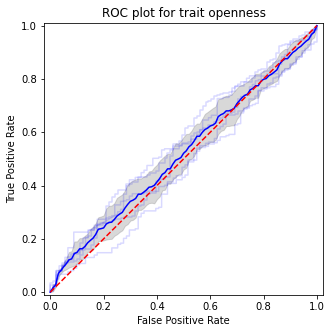

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

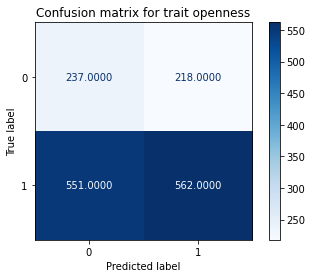


Trait to predict:  conscientiousness ( log )

Average accuracy:  0.5044931930567144


Average f1 macro score:  0.4882649498521071


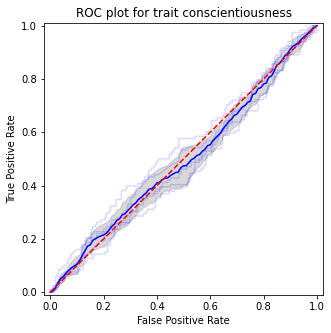

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

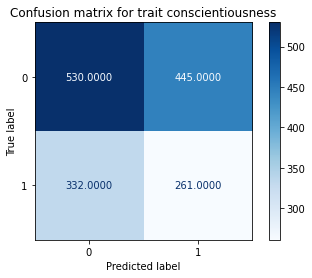


Trait to predict:  extraversion ( log )

Average accuracy:  0.5523168026698684


Average f1 macro score:  0.5153140380955693


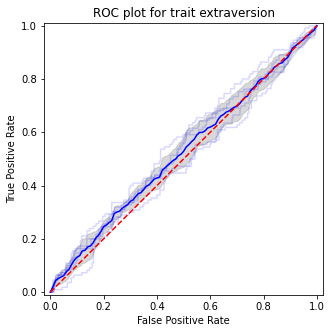

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

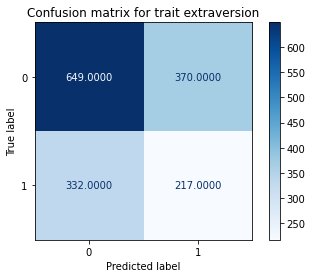


Trait to predict:  agreeableness ( log )

Average accuracy:  0.5708329093832034


Average f1 macro score:  0.5643744270852942


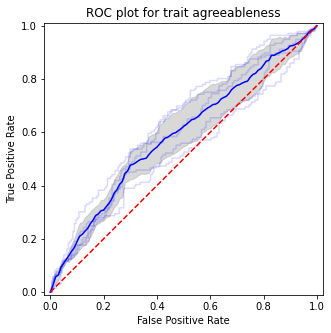

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

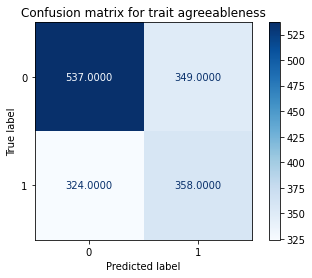


Trait to predict:  neuroticism ( log )

Average accuracy:  0.530607842738243


Average f1 macro score:  0.5302251187268947


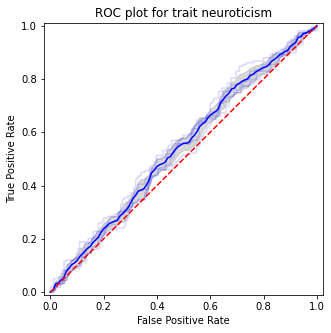

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

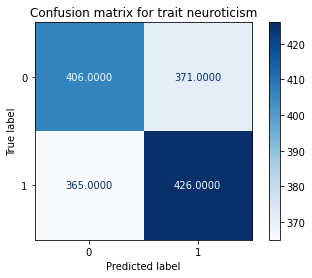

Total accuracy:  0.5335599999999999 Total F1 macro:  0.5169
Time for entire process: 802.62s


In [31]:
classify_cv(df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=5)

Current time:  2021-05-15 21:19:08.073870
Classifier:  log 


Trait to predict:  openness ( log )

Average accuracy:  0.5025803300706132


Average f1 macro score:  0.47879710763692634


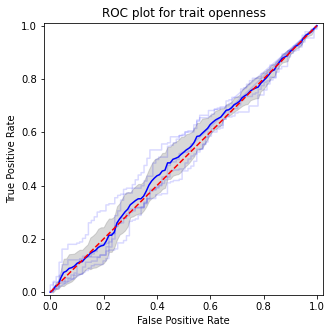

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

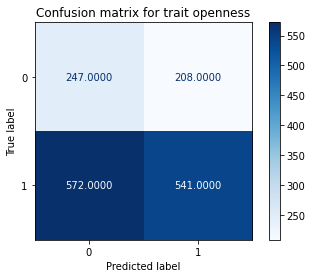


Trait to predict:  conscientiousness ( log )

Average accuracy:  0.5287295740827415


Average f1 macro score:  0.4745567179867497


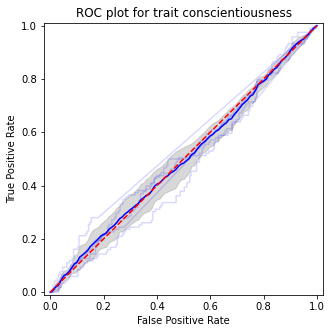

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

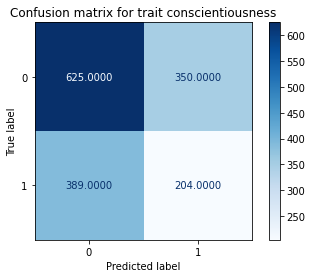


Trait to predict:  extraversion ( log )

Average accuracy:  0.5446694206467105


Average f1 macro score:  0.5008220643906377


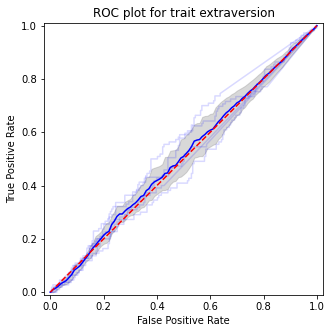

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

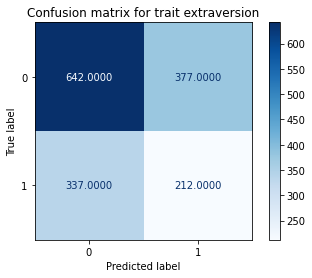


Trait to predict:  agreeableness ( log )

Average accuracy:  0.5561771229726705


Average f1 macro score:  0.5440042472319282


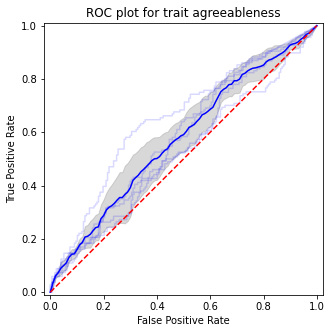

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

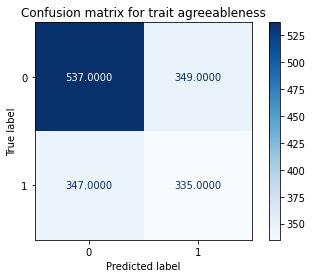


Trait to predict:  neuroticism ( log )

Average accuracy:  0.5191082802547771


Average f1 macro score:  0.5047831851070064


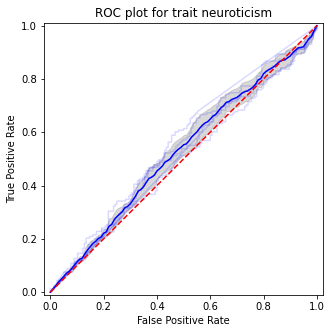

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

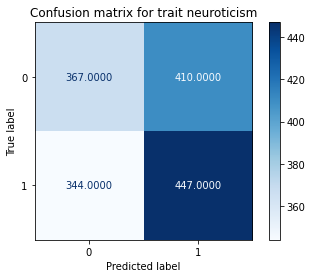

Total accuracy:  0.53026 Total F1 macro:  0.5006
Time for entire process: 803.11s


In [32]:
classify_cv(df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=1)

Current time:  2021-05-15 21:32:31.193203
Classifier:  log 


Trait to predict:  openness ( log )

Average accuracy:  0.5574184489530127


Average f1 macro score:  0.5214152169104863


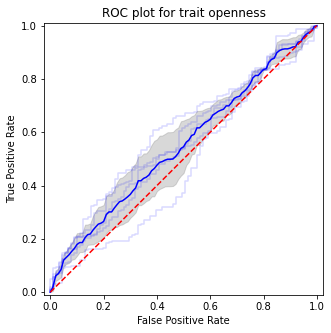

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

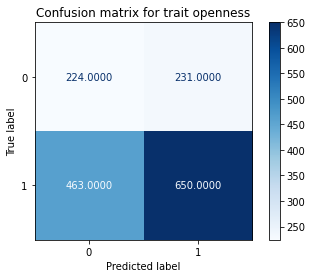


Trait to predict:  conscientiousness ( log )

Average accuracy:  0.5459799352882522


Average f1 macro score:  0.5317996876534493


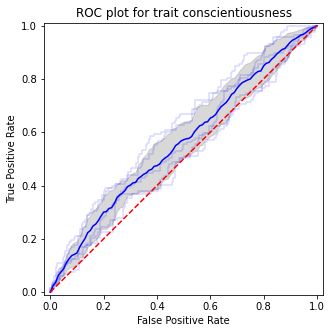

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

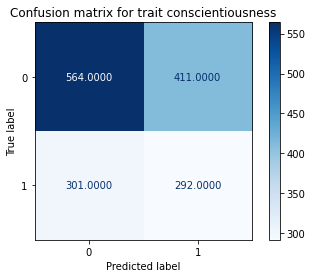


Trait to predict:  extraversion ( log )

Average accuracy:  0.6033454752650536


Average f1 macro score:  0.5765795774887972


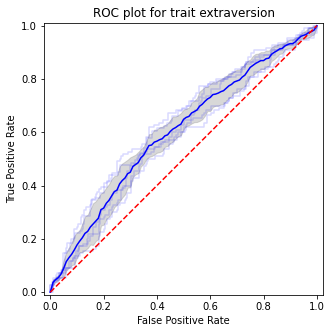

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

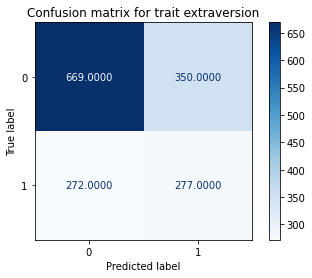


Trait to predict:  agreeableness ( log )

Average accuracy:  0.5561567733664353


Average f1 macro score:  0.5523350742110419


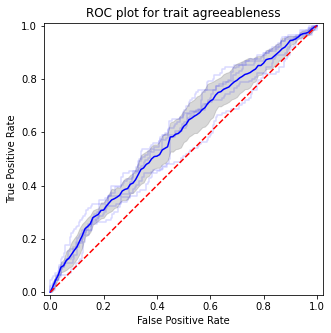

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

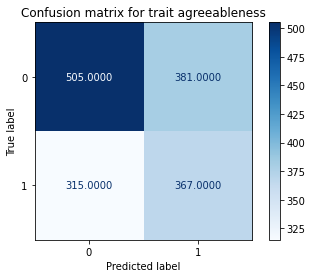


Trait to predict:  neuroticism ( log )

Average accuracy:  0.5637899106652287


Average f1 macro score:  0.5626646705436161


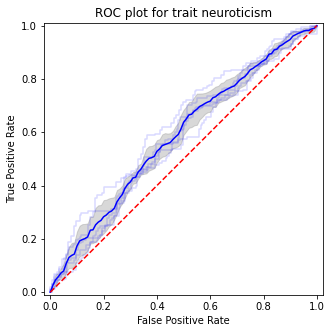

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

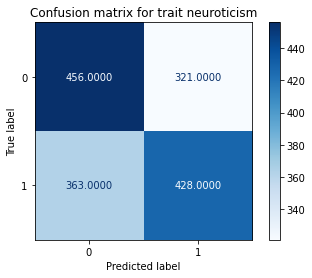

Total accuracy:  0.5653400000000001 Total F1 macro:  0.54896
Time for entire process: 853.83s


In [33]:
classify_cv(df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=100)

In [ ]:
classify_cv(df, big5_traits, 'binary', ['log'], 'anova', dim=True, n_feat=30)

### Classifiers

In [ ]:
# compare clfs
classify_cv(df, big5_traits, 'binary', onlynew_clf, 'anova', dim=False, n_feat=30)

### Feature selection algorithms

LR with mutual info feature selection
Current time:  2021-05-15 22:09:25.304205
Classifier:  log 


Trait to predict:  openness ( log )

Average accuracy:  0.5267882216479112


Average f1 macro score:  0.5003816244787326


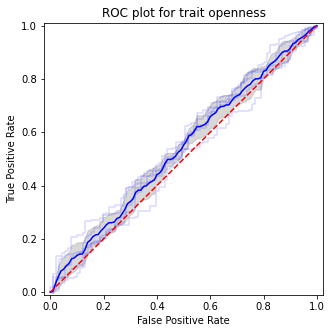

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

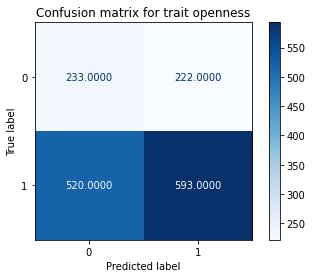


Trait to predict:  conscientiousness ( log )

Average accuracy:  0.5197940619849005


Average f1 macro score:  0.5126187941998641


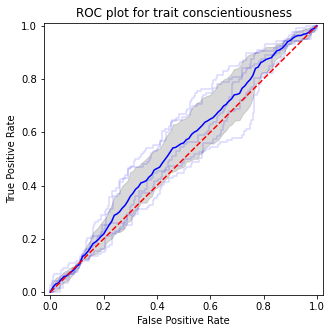

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

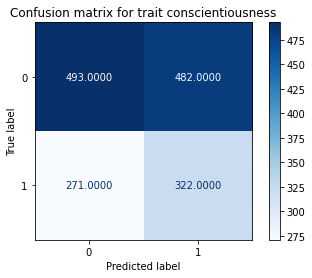


Trait to predict:  extraversion ( log )

Average accuracy:  0.5114873527197248


Average f1 macro score:  0.49631955089085816


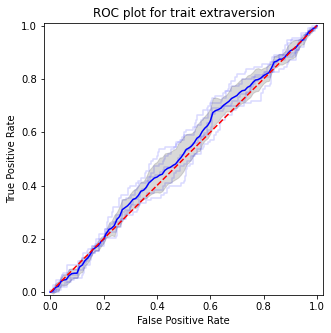

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

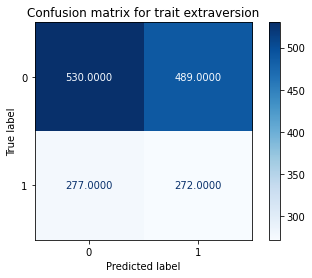


Trait to predict:  agreeableness ( log )

Average accuracy:  0.5395392849148368


Average f1 macro score:  0.5381583535356382


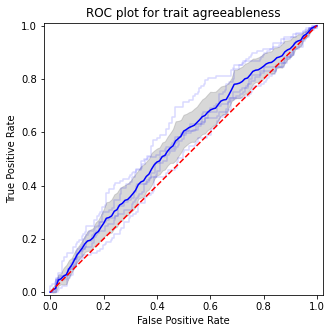

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

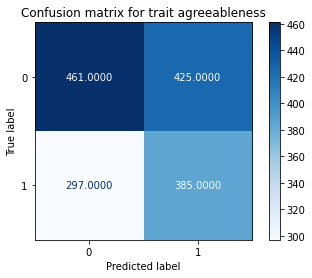


Trait to predict:  neuroticism ( log )

Average accuracy:  0.5101829429600537


Average f1 macro score:  0.509039718870031


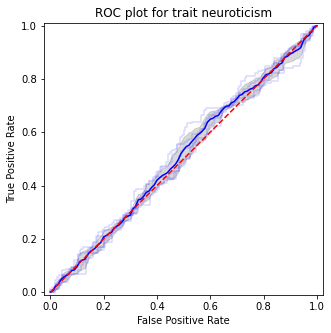

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

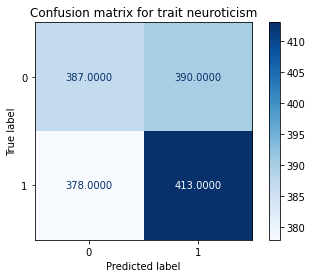

Total accuracy:  0.52156 Total F1 macro:  0.5113
Time for entire process: 2070.91s
Classifier:  mlp 


Trait to predict:  openness ( mlp )

Average accuracy:  0.6830284283999105


Average f1 macro score:  0.48355989314163095


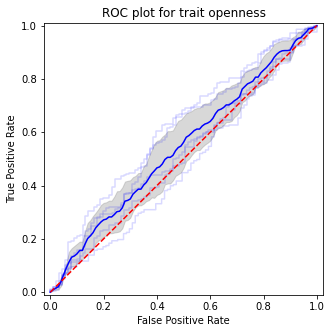

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

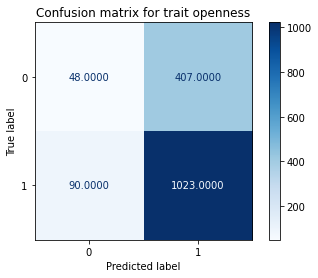


Trait to predict:  conscientiousness ( mlp )

Average accuracy:  0.5810239921857512


Average f1 macro score:  0.489549568289417


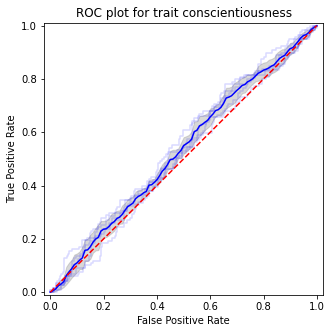

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

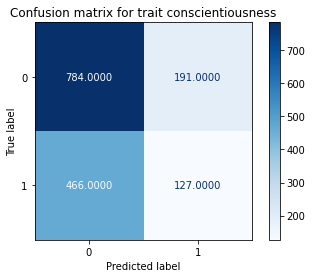


Trait to predict:  extraversion ( mlp )

Average accuracy:  0.6186219246657577


Average f1 macro score:  0.5108166328047896


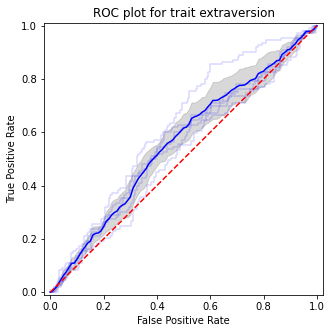

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

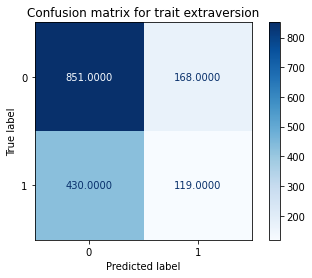


Trait to predict:  agreeableness ( mlp )

Average accuracy:  0.5759040312569952


Average f1 macro score:  0.5449088010280716


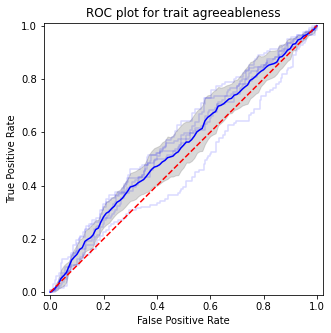

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

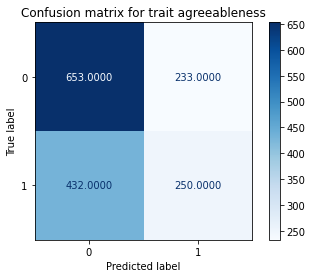


Trait to predict:  neuroticism ( mlp )

Average accuracy:  0.5095785596548705


Average f1 macro score:  0.5089613362973813


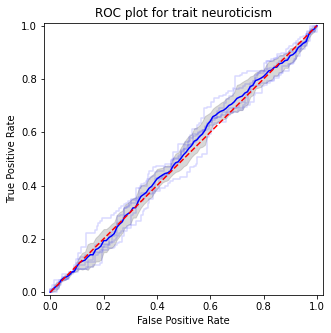

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

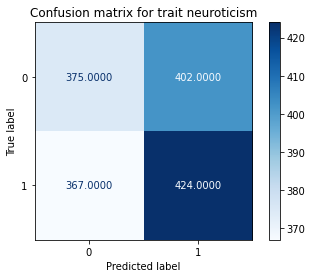

Total accuracy:  0.5936199999999999 Total F1 macro:  0.50756
Time for entire process: 2843.05s
Classifier:  svm 


Trait to predict:  openness ( svm )

Average accuracy:  0.5892676176715981


Average f1 macro score:  0.497288727718344


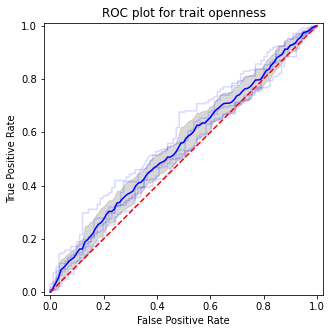

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

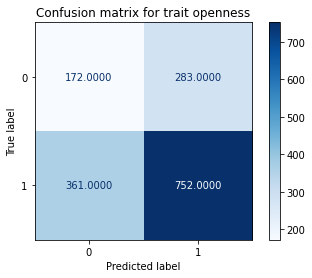


Trait to predict:  conscientiousness ( svm )

Average accuracy:  0.49044585987261147


Average f1 macro score:  0.4786881591147171


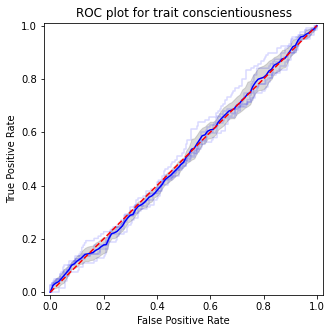

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

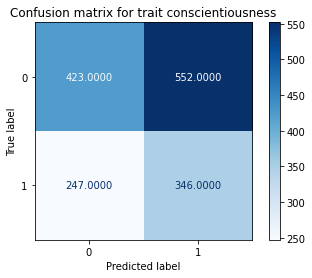


Trait to predict:  extraversion ( svm )

Average accuracy:  0.47574733928898477


Average f1 macro score:  0.4531118201443348


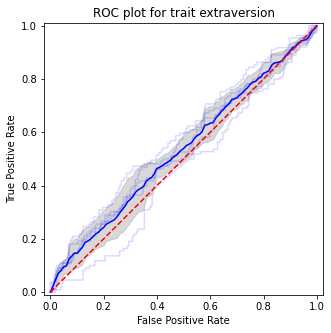

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

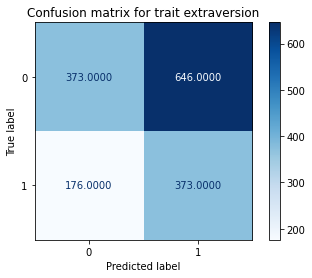


Trait to predict:  agreeableness ( svm )

Average accuracy:  0.5287112594371299


Average f1 macro score:  0.5245880010550625


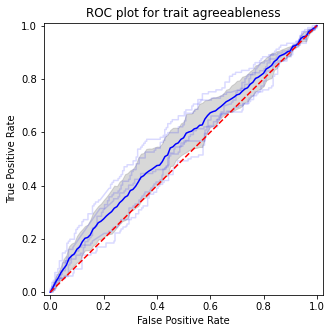

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

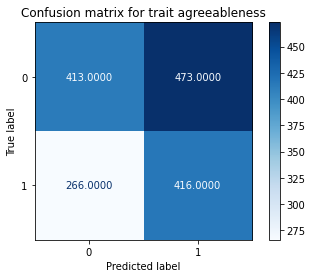


Trait to predict:  neuroticism ( svm )

Average accuracy:  0.5063836714759569


Average f1 macro score:  0.48879453264461825


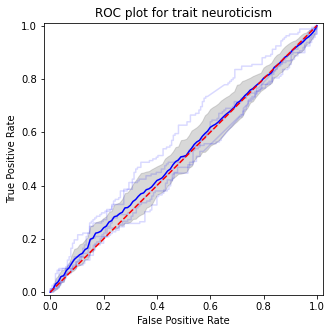

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

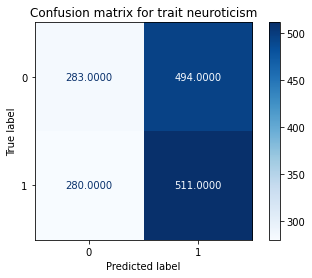

Total accuracy:  0.5181000000000001 Total F1 macro:  0.4885
Time for entire process: 8699.28s
Classifier:  nb 


Trait to predict:  openness ( nb )

Average accuracy:  0.5554445371482062


Average f1 macro score:  0.41558087325421794


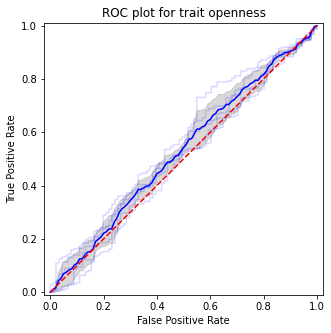

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

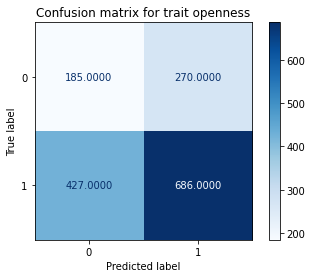


Trait to predict:  conscientiousness ( nb )

Average accuracy:  0.4534930099102583


Average f1 macro score:  0.3979485009881226


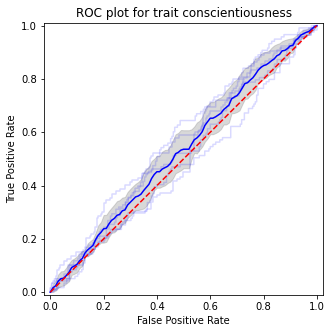

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

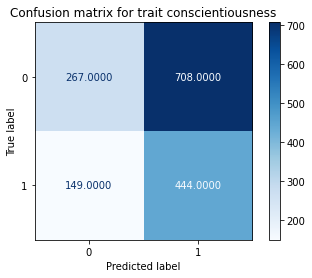


Trait to predict:  extraversion ( nb )

Average accuracy:  0.44127103640544557


Average f1 macro score:  0.3846876511961218


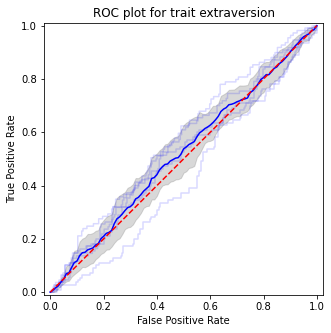

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

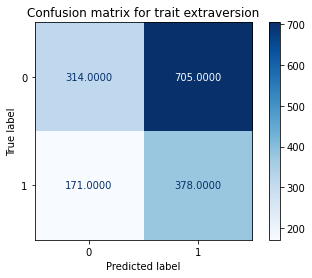


Trait to predict:  agreeableness ( nb )

Average accuracy:  0.535044056897499


Average f1 macro score:  0.41532342461126925


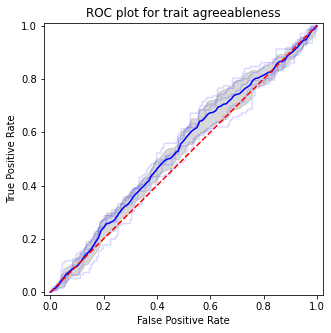

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

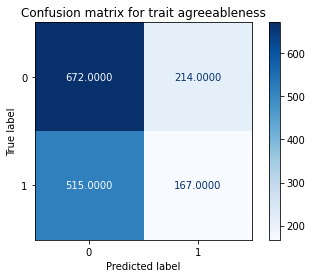


Trait to predict:  neuroticism ( nb )

Average accuracy:  0.5025233511731548


Average f1 macro score:  0.4129766957264037


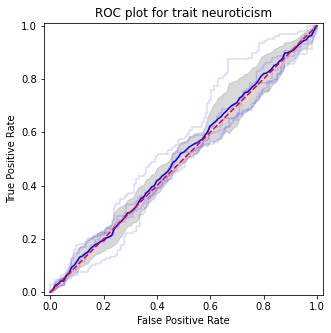

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

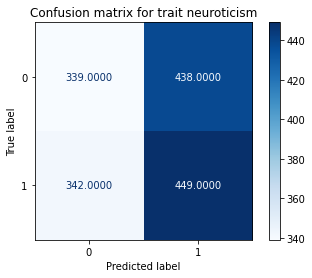

Total accuracy:  0.49754000000000004 Total F1 macro:  0.4053
Time for entire process: 9056.91s
Classifier:  tree 


Trait to predict:  openness ( tree )

Average accuracy:  0.54458802222177


Average f1 macro score:  0.5030313974673537


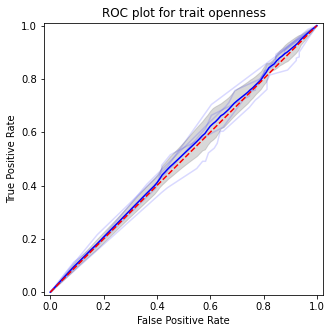

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

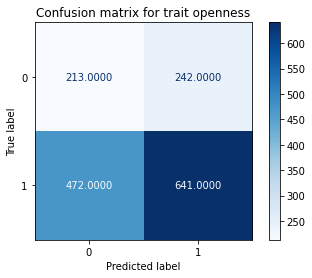


Trait to predict:  conscientiousness ( tree )

Average accuracy:  0.5159337416820984


Average f1 macro score:  0.5020282112399841


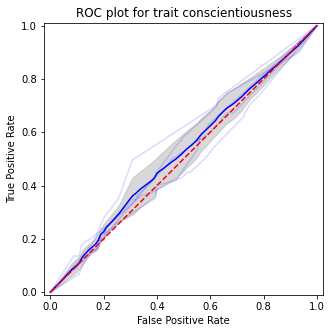

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

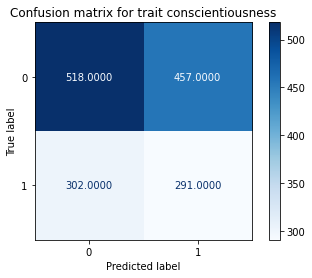


Trait to predict:  extraversion ( tree )

Average accuracy:  0.5159418815245924


Average f1 macro score:  0.502945870844852


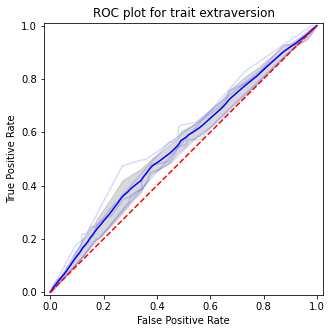

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

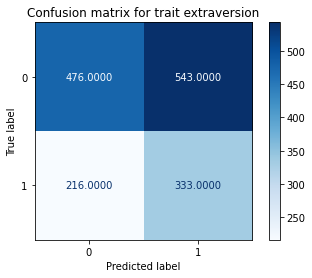


Trait to predict:  agreeableness ( tree )

Average accuracy:  0.5567876111597241


Average f1 macro score:  0.5454780391059503


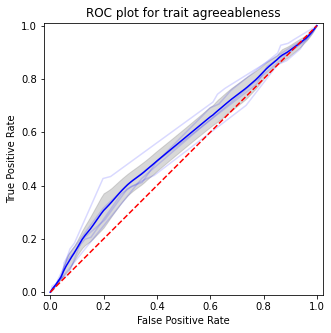

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

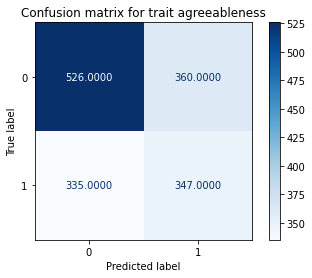


Trait to predict:  neuroticism ( tree )

Average accuracy:  0.48598115626462635


Average f1 macro score:  0.4829978379960713


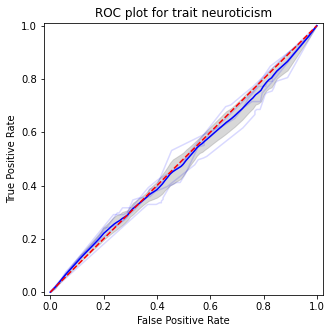

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

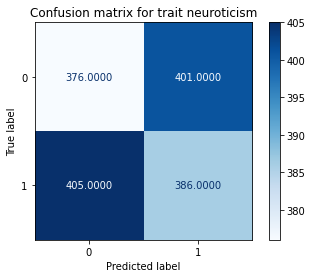

Total accuracy:  0.5238400000000001 Total F1 macro:  0.50728
Time for entire process: 9779.53s
Classifier:  rfc 


Trait to predict:  openness ( rfc )

Average accuracy:  0.6007753199975581


Average f1 macro score:  0.5440929291445661


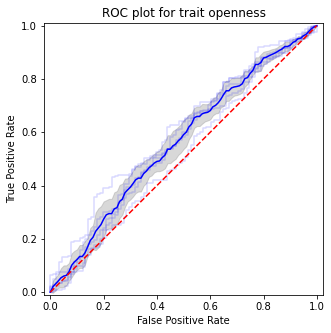

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

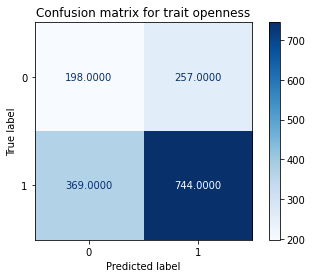


Trait to predict:  conscientiousness ( rfc )

Average accuracy:  0.5338332553265095


Average f1 macro score:  0.5172579997912794


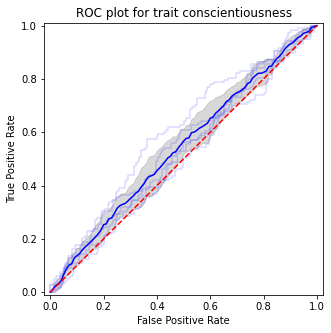

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

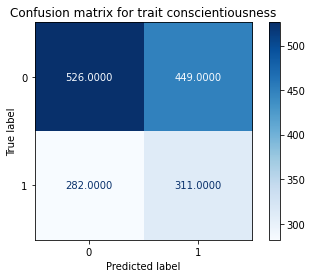


Trait to predict:  extraversion ( rfc )

Average accuracy:  0.5491198795303311


Average f1 macro score:  0.5190527709515841


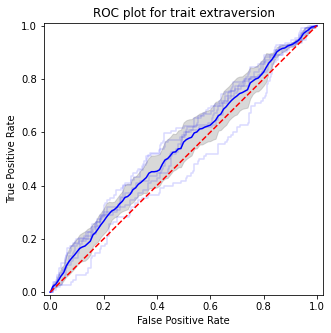

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

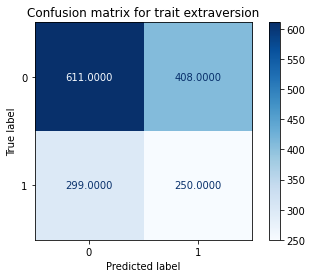


Trait to predict:  agreeableness ( rfc )

Average accuracy:  0.549103599845343


Average f1 macro score:  0.535637636460532


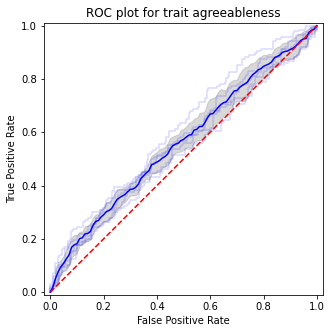

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

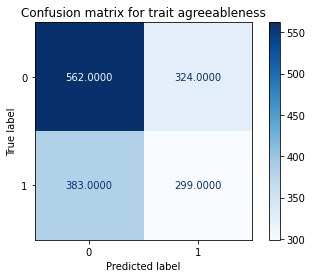


Trait to predict:  neuroticism ( rfc )

Average accuracy:  0.5287132943977534


Average f1 macro score:  0.5281715137138207


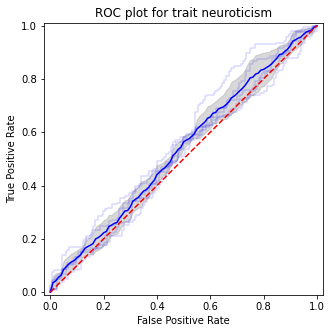

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

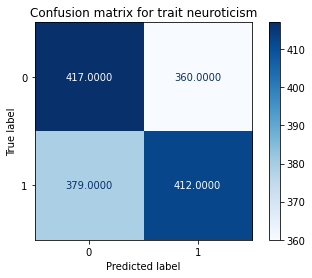

Total accuracy:  0.5523 Total F1 macro:  0.52886
Time for entire process: 10536.76s
Classifier:  ada 


Trait to predict:  openness ( ada )



UnboundLocalError: local variable 'params' referenced before assignment

<Figure size 360x360 with 0 Axes>

In [35]:
print("New clfs with mutual info feature selection")
classify_cv(df, big5_traits, 'binary', exp_clf, 'mutual', dim=True, n_feat=10)

CLF with mutual info feature selection and anova
Current time:  2021-05-16 17:46:34.475512
Classifier:  log 


Trait to predict:  openness ( log )

Average accuracy:  0.5363728861846523


Average f1 macro score:  0.5155844555635407


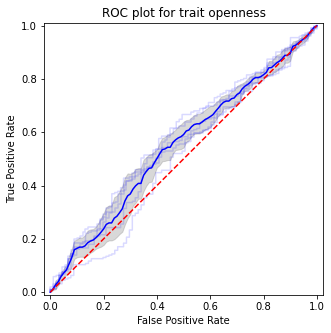

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

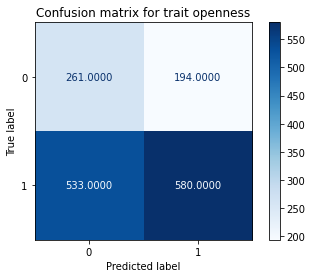


Trait to predict:  conscientiousness ( log )

Average accuracy:  0.5280722818013471


Average f1 macro score:  0.5128728633752543


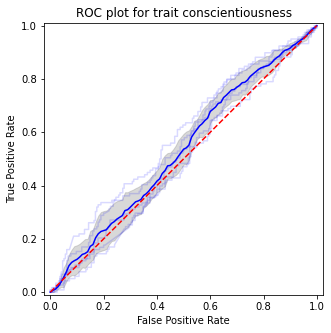

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

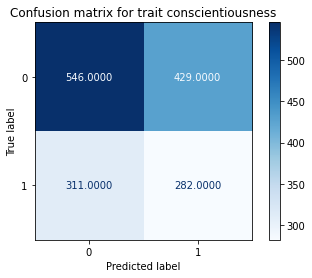


Trait to predict:  extraversion ( log )

Average accuracy:  0.565727193178812


Average f1 macro score:  0.5438775651186761


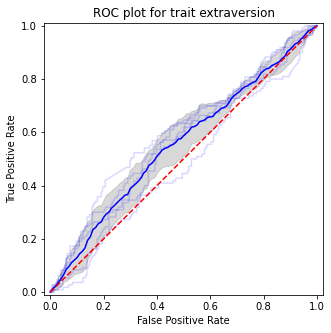

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

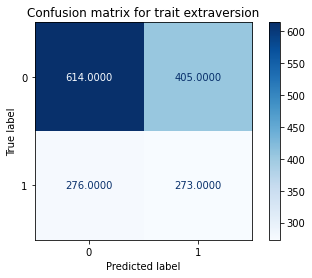


Trait to predict:  agreeableness ( log )

Average accuracy:  0.5568018558840887


Average f1 macro score:  0.5540101842943088


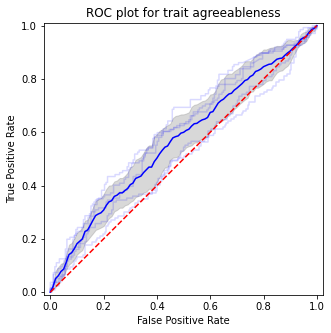

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

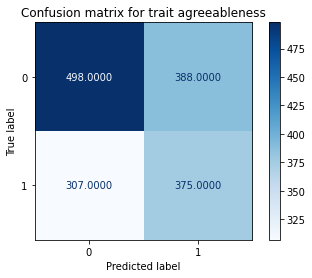


Trait to predict:  neuroticism ( log )

Average accuracy:  0.5612177204371095


Average f1 macro score:  0.5600594231283529


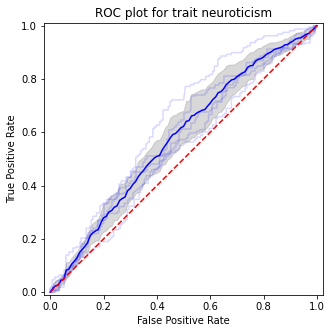

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

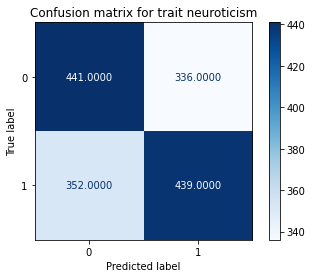

Total accuracy:  0.5496399999999999 Total F1 macro:  0.5373000000000001
Time for entire process: 944.21s
Classifier:  mlp 


Trait to predict:  openness ( mlp )

Average accuracy:  0.6728658350460919


Average f1 macro score:  0.47670698053748356


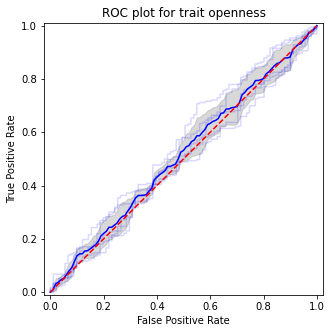

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

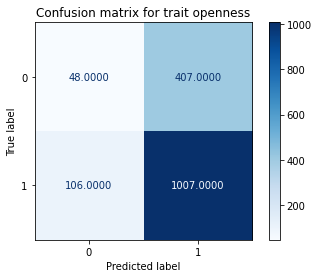


Trait to predict:  conscientiousness ( mlp )

Average accuracy:  0.5924767505748763


Average f1 macro score:  0.5109611261590621


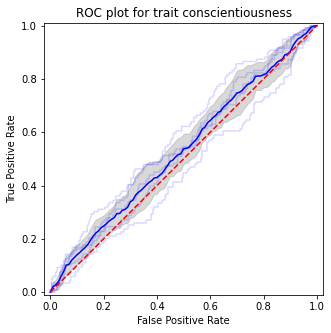

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

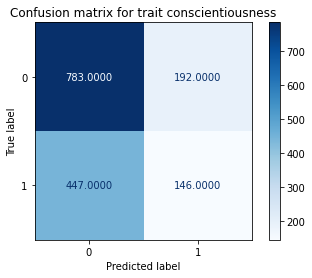


Trait to predict:  extraversion ( mlp )

Average accuracy:  0.6218127429234244


Average f1 macro score:  0.4949694504366695


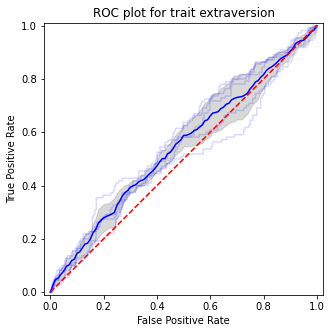

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

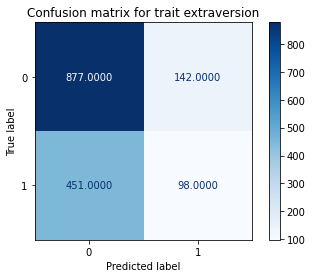


Trait to predict:  agreeableness ( mlp )

Average accuracy:  0.5682607191550844


Average f1 macro score:  0.5351243861818653


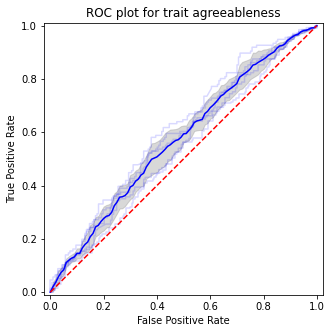

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

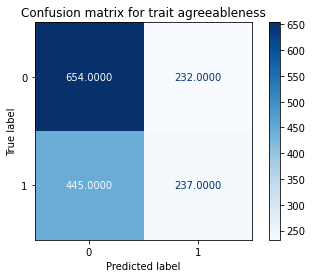


Trait to predict:  neuroticism ( mlp )

Average accuracy:  0.5478602389043772


Average f1 macro score:  0.5457135876373782


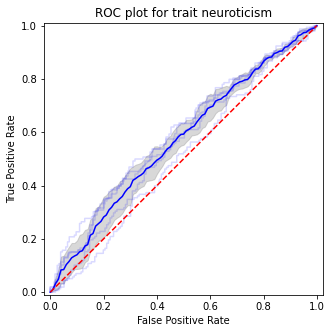

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

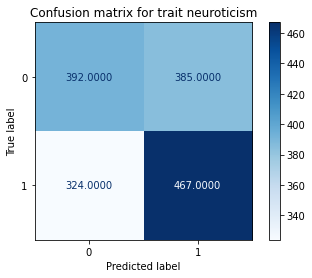

Total accuracy:  0.60068 Total F1 macro:  0.5126999999999999
Time for entire process: 1406.09s
Classifier:  rfc 


Trait to predict:  openness ( rfc )

Average accuracy:  0.587983557518162


Average f1 macro score:  0.5207787854304924


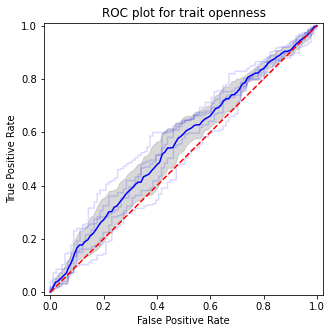

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

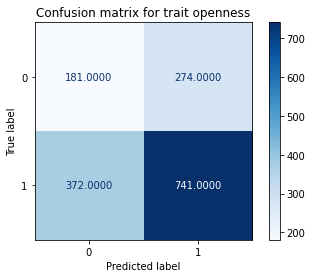


Trait to predict:  conscientiousness ( rfc )

Average accuracy:  0.5618566980728923


Average f1 macro score:  0.5205884386960669


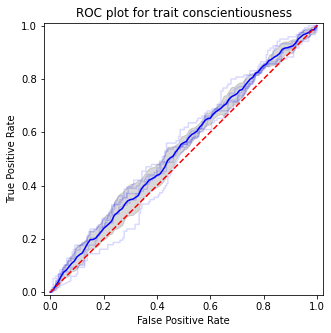

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

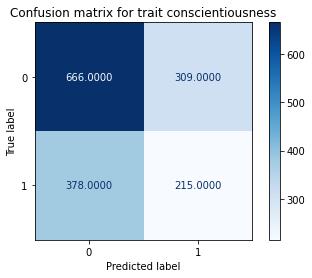


Trait to predict:  extraversion ( rfc )

Average accuracy:  0.575279298345577


Average f1 macro score:  0.5341782371981942


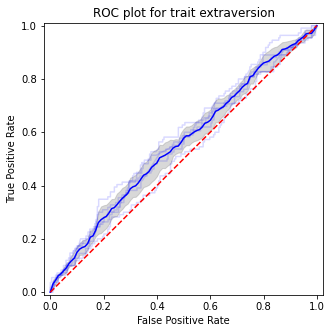

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

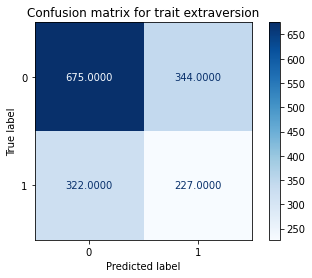


Trait to predict:  agreeableness ( rfc )

Average accuracy:  0.5325715797399321


Average f1 macro score:  0.5235824333469155


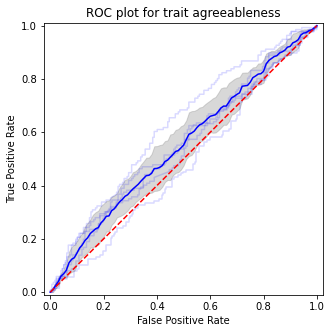

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

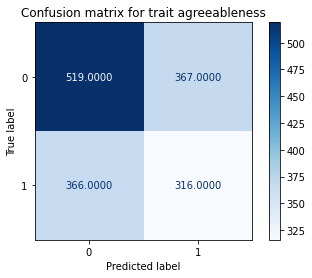


Trait to predict:  neuroticism ( rfc )

Average accuracy:  0.53828371421013


Average f1 macro score:  0.5351663880800767


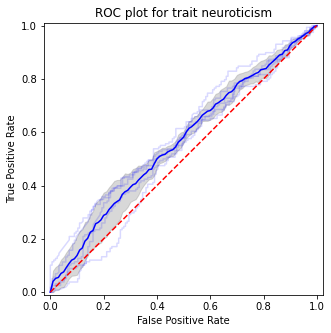

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

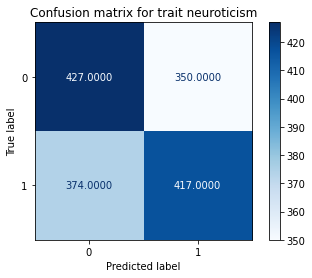

Total accuracy:  0.55922 Total F1 macro:  0.52688
Time for entire process: 1763.89s
Classifier:  boost 


Trait to predict:  openness ( boost )

Average accuracy:  0.6154392462505851


Average f1 macro score:  0.4846311814497376


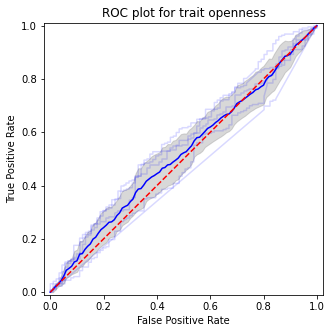

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

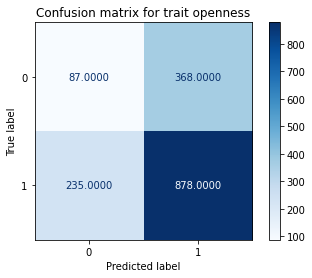


Trait to predict:  conscientiousness ( boost )

Average accuracy:  0.5574204839136364


Average f1 macro score:  0.5043738411059725


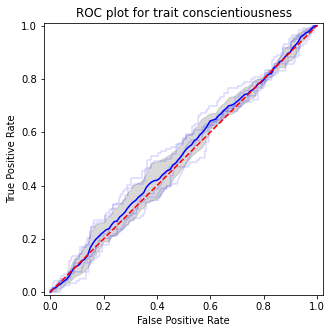

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

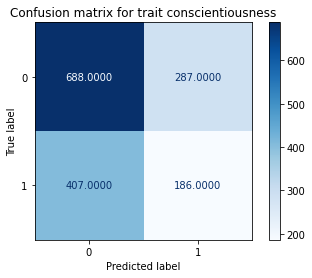


Trait to predict:  extraversion ( boost )

Average accuracy:  0.6141450112940314


Average f1 macro score:  0.5385973060040834


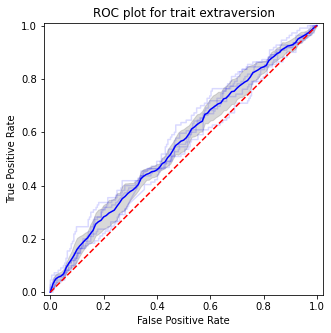

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

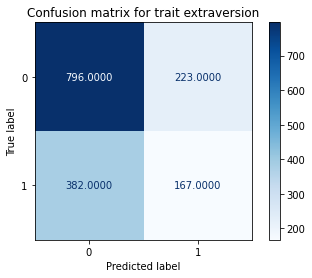


Trait to predict:  agreeableness ( boost )

Average accuracy:  0.5663376813658656


Average f1 macro score:  0.5459524655227325


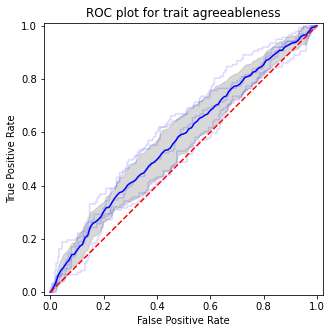

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

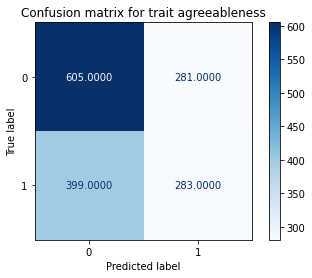


Trait to predict:  neuroticism ( boost )

Average accuracy:  0.5216845404041432


Average f1 macro score:  0.5187883804806928


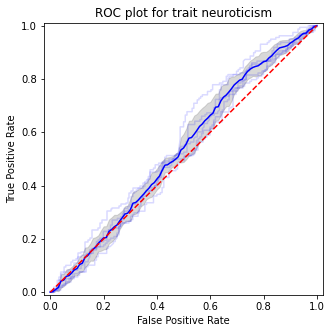

Total number of users in confusion matrix:  1568


<Figure size 360x360 with 0 Axes>

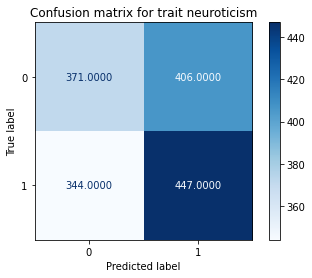

Total accuracy:  0.57498 Total F1 macro:  0.51848
Time for entire process: 2545.31s


In [33]:
print("CLF with mutual info feature selection and anova")
classify_cv(df, big5_traits, 'binary', exp_clf , 'mutual', dim=False, n_feat=10, doublefs=True)

CLF with backward sequential feature selection and pca
Current time:  2021-05-16 18:28:59.793333
Classifier:  log 


Trait to predict:  openness ( log )



KeyboardInterrupt: 

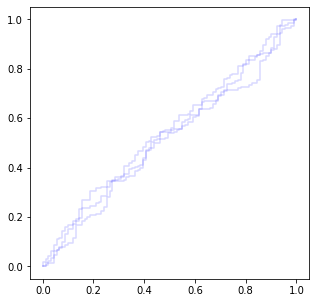

In [34]:
print("CLF with backward sequential feature selection and pca")
classify_cv(df, big5_traits, 'binary', exp_clf, 'sequential_backward', dim=True, n_feat=10)

In [ ]:
print("CLF with backward sequential feature selection and anova")
classify_cv(df, big5_traits, 'binary', exp_clf, 'sequential_backward', dim=False, n_feat=10, doublefs=True)

In [ ]:
print("CLF with forward sequential feature selection and anova")
classify_cv(df, big5_traits, 'binary', exp_clf, 'sequential_forward', dim=True, n_feat=10)

In [ ]:
print("CLF with forward sequential feature selection and anova")
classify_cv(df, big5_traits, 'binary', exp_clf, 'sequential_forward', dim=False, n_feat=10, doublefs=True)

## MBTI

Current time:  2021-05-16 17:02:54.116155
Classifier:  log 


Trait to predict:  mbti_ei ( log )

Average accuracy:  0.6993339993339993


Average f1 macro score:  0.6480256633839301


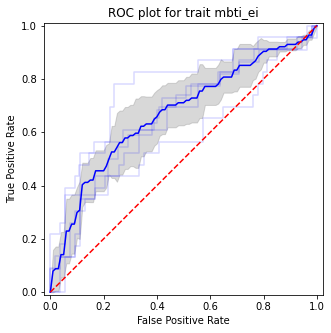

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

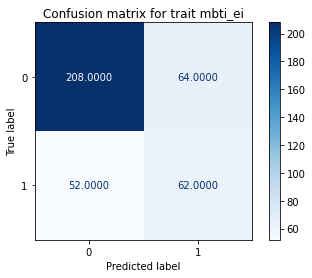


Trait to predict:  mbti_ns ( log )

Average accuracy:  0.8082917082917083


Average f1 macro score:  0.5640813694533046


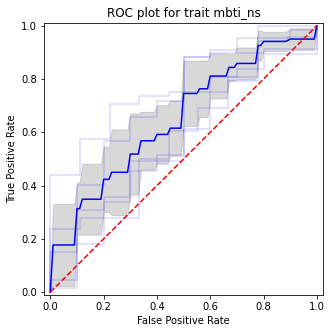

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

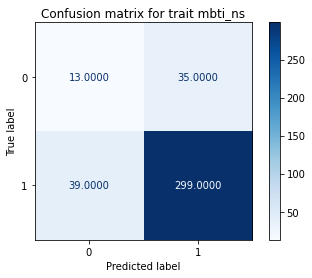


Trait to predict:  mbti_tf ( log )

Average accuracy:  0.7382284382284382


Average f1 macro score:  0.7237824782484543


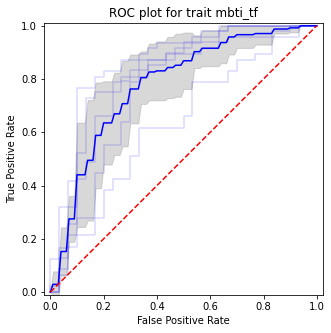

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

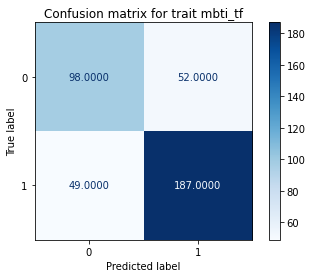


Trait to predict:  mbti_jp ( log )

Average accuracy:  0.7098235098235098


Average f1 macro score:  0.7055354512909233


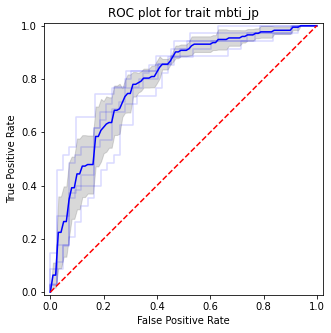

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

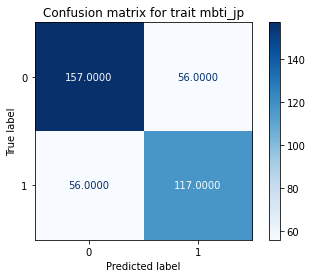

Total accuracy:  0.7389 Total F1 macro:  0.66035
Time for entire process: 140.12s


In [26]:
classify_cv(mbtidf, mbti_traits, 'mbti', ['log'], 'anova', dim=False, n_feat=30)

Current time:  2021-05-16 17:28:51.893757
Classifier:  log 


Trait to predict:  mbti_ei ( log )

Average accuracy:  0.7356310356310357


Average f1 macro score:  0.6799212011832575


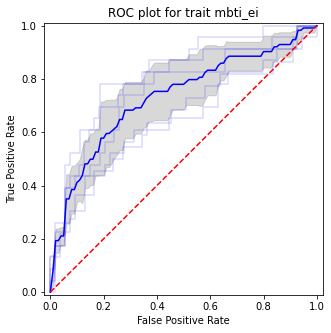

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

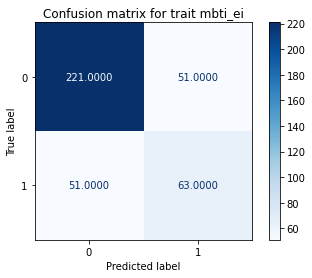


Trait to predict:  mbti_ns ( log )

Average accuracy:  0.8084582084582085


Average f1 macro score:  0.6004742803680789


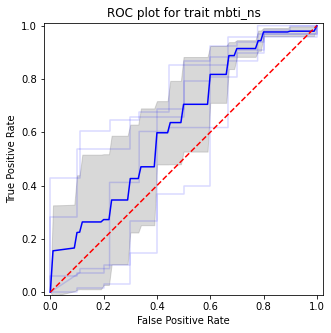

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

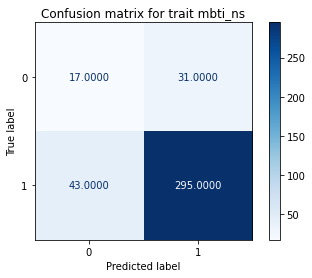


Trait to predict:  mbti_tf ( log )

Average accuracy:  0.6916416916416915


Average f1 macro score:  0.677474364222385


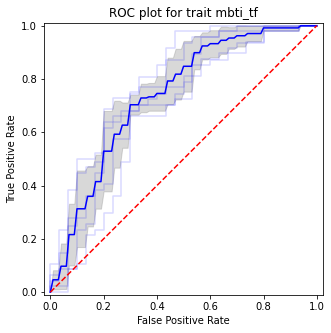

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

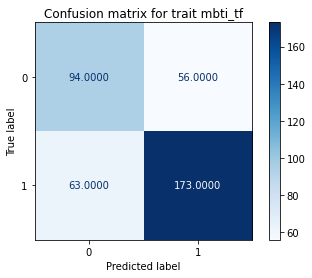


Trait to predict:  mbti_jp ( log )

Average accuracy:  0.7202797202797202


Average f1 macro score:  0.7182438082584675


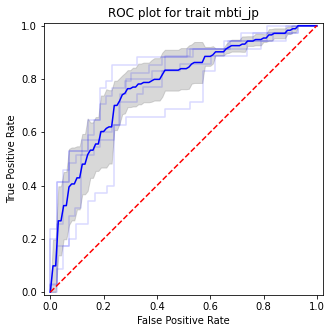

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

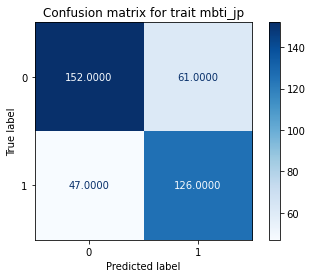

Total accuracy:  0.739 Total F1 macro:  0.669025
Time for entire process: 129.82s


In [30]:
classify_cv(mbtidf, mbti_traits, 'mbti', ['log'], 'anova', dim=False, n_feat=10)

Current time:  2021-05-16 17:31:01.719930
Classifier:  log 


Trait to predict:  mbti_ei ( log )

Average accuracy:  0.7278388278388278


Average f1 macro score:  0.6745609975620884


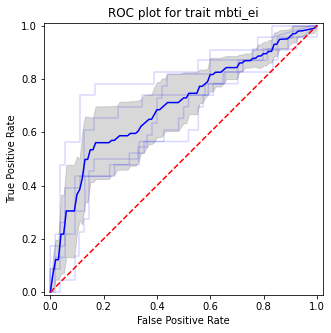

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

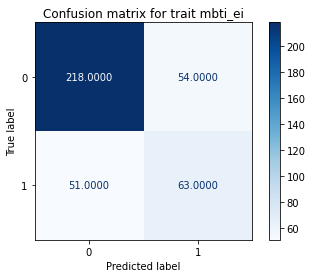


Trait to predict:  mbti_ns ( log )

Average accuracy:  0.7980685980685982


Average f1 macro score:  0.5733186231696293


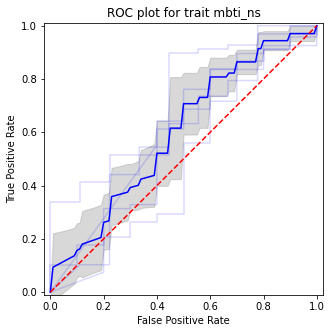

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

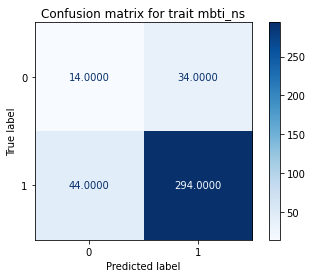


Trait to predict:  mbti_tf ( log )

Average accuracy:  0.6967698967698969


Average f1 macro score:  0.6826654432187679


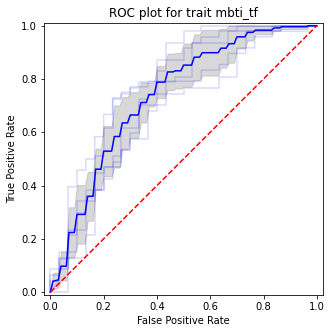

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

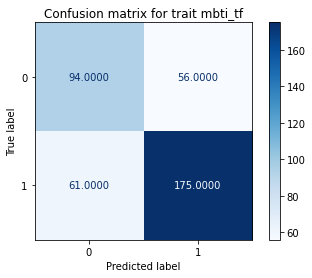


Trait to predict:  mbti_jp ( log )

Average accuracy:  0.6476523476523476


Average f1 macro score:  0.6467960988111829


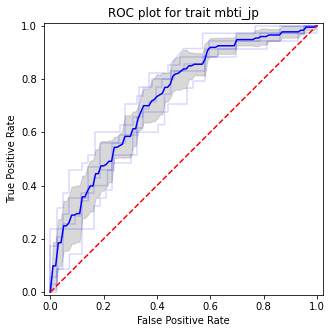

Total number of users in confusion matrix:  386


<Figure size 360x360 with 0 Axes>

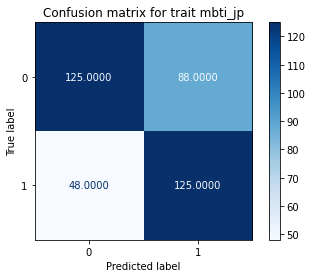

Total accuracy:  0.7176 Total F1 macro:  0.64435
Time for entire process: 131.11s


In [31]:
classify_cv(mbtidf, mbti_traits, 'mbti', ['log'], 'anova', dim=False, n_feat=5)

In [ ]:
classify_cv(mbtidf, mbti_traits, 'mbti', ['log'], 'anova', dim=False, n_feat=30, train=True)